In [1]:
import pandas as pd
import numpy as np
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.model_selection import train_test_split
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import pickle
import matplotlib.pyplot as plt

# Hide ipykernel warnings 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%config IPCompleter.greedy=True

# Prepare the data

## Read data into a dataframe

In [2]:
# Reading from csv files into dataframes
df_availability = pd.read_csv('hourly_availability.csv', keep_default_na=True, delimiter=',', skipinitialspace=True, parse_dates=['hourly_update'])
df_weather = pd.read_csv('hourly_weather_forcast.csv', keep_default_na=True, delimiter=',', skipinitialspace=True, parse_dates=['hourly_update'])
# Standardize the format of datetime
df_availability['hourly_update'] = df_availability['hourly_update'].dt.strftime('%Y-%m-%d %H:%M:%S')
df_weather['hourly_update'] = df_weather['hourly_update'].dt.strftime('%Y-%m-%d %H:%M:%S')
# Concatenate to get a whole dataframe
df = pd.merge(df_availability, df_weather, left_on='hourly_update', right_on='hourly_update', how='inner')

## A glimpse of the data

In [3]:
# Check how many rows and columns the dataset has
df.shape

(100677, 14)

In [4]:
# Display the data types in each column as assigned by default
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100677 entries, 0 to 100676
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   number                100677 non-null  int64  
 1   hourly_update         100677 non-null  object 
 2   bike_stands           100677 non-null  int64  
 3   avg_available_bikes   100677 non-null  float64
 4   avg_available_stands  100677 non-null  float64
 5   weather_main          100677 non-null  object 
 6   weather_des           100677 non-null  object 
 7   temp                  100677 non-null  float64
 8   feels_like            100677 non-null  float64
 9   wind_speed            100677 non-null  float64
 10  cloudiness            100677 non-null  int64  
 11  visibility            100677 non-null  int64  
 12  pop                   100677 non-null  float64
 13  rain_1h               100677 non-null  float64
dtypes: float64(7), int64(4), object(3)
memory usage: 10.

In [5]:
# Print a few rows for checking
df.sample(10)

number        hourly_update  bike_stands  avg_available_bikes  \
70898      93  2024-03-28 17:00:00           40              19.8000   
3574      108  2024-03-04 01:00:00           35              16.0000   
73651     110  2024-03-29 17:00:00           40              12.0000   
10569     100  2024-03-06 15:00:00           25              19.3333   
10498      26  2024-03-06 15:00:00           20              14.8889   
50271      99  2024-03-21 04:00:00           30               0.0000   
96185      71  2024-04-06 23:00:00           40              15.7143   
44149      13  2024-03-18 23:00:00           30               5.0000   
86873     108  2024-04-03 13:00:00           35               9.2857   
35914     103  2024-03-15 22:00:00           40               5.0000   

       avg_available_stands weather_main       weather_des   temp  feels_like  \
70898               20.2000       Clouds     broken clouds   9.29        8.29   
3574                19.0000       Clouds  scattered clouds   2.71        1.01   
73651               28.0000         Rain        light rain  12.00       11.16   
10569                5.6667       Clouds     broken clouds   9.71        7.13   
10498                5.1111       Clouds     broken clouds   9.71        7.13   
50271               30.0000        Clear         clear sky   8.23        6.12   
96185               24.2857         Rain        light rain   9.75        6.11   
44149               24.0000       Clouds     broken clouds  12.74       12.21   
86873               25.7143       Clouds     broken clouds  11.06       10.31   
35914               35.0000        Clear         clear sky   5.69        4.77   

       wind_speed  cloudiness  visibility   pop  rain_1h  
70898        2.09          75       10000  0.43     0.00  
3574         1.74          40       10000  0.04     0.00  
73651        3.21          75       10000  0.65     0.25  
10569        5.26          75       10000  0.00     0.00  
10498        5.26          75       10000  0.00     0.00  
50271        3.44           0       10000  0.00     0.00  
96185        8.98          20       10000  0.34     0.13  
44149        7.88          75       10000  0.72     0.00  
86873        3.74          75       10000  0.36     0.00  
35914        1.47           0       10000  0.00     0.00

In [6]:
# Descriptive stats for continuous features
df.describe().T

count         mean          std     min         25%  \
number                100677.0    58.821667    34.150143    1.00     29.0000   
bike_stands           100677.0    31.971980     7.459712   16.00     29.0000   
avg_available_bikes   100677.0    11.708502     9.857908    0.00      3.0000   
avg_available_stands  100677.0    20.155052    11.193082    0.00     11.6667   
temp                  100677.0     8.889654     2.675855    2.25      7.2900   
feels_like            100677.0     6.911743     3.628573   -1.04      4.2100   
wind_speed            100677.0     4.823104     2.400610    0.20      2.8600   
cloudiness            100677.0    63.827528    20.503956    0.00     40.0000   
visibility            100677.0  9702.577590  1267.074179  190.00  10000.0000   
pop                   100677.0     0.331906     0.351550    0.00      0.0000   
rain_1h               100677.0     0.131546     0.323481    0.00      0.0000   

                            50%         75%       max  
number                   58.000     89.0000    117.00  
bike_stands              30.000     40.0000     40.00  
avg_available_bikes       9.875     18.0833     40.00  
avg_available_stands     20.000     29.0000     40.00  
temp                      8.490     10.7500     15.29  
feels_like                6.410      9.9100     14.78  
wind_speed                4.710      6.4600     12.30  
cloudiness               75.000     75.0000    100.00  
visibility            10000.000  10000.0000  10000.00  
pop                       0.200      0.6500      1.00  
rain_1h                   0.000      0.1300      2.36

## Check for missing values

In [7]:
# Look at the rows with missing value for feature 'number'
df[df['number'].isnull()]

Empty DataFrame
Columns: [number, hourly_update, bike_stands, avg_available_bikes, avg_available_stands, weather_main, weather_des, temp, feels_like, wind_speed, cloudiness, visibility, pop, rain_1h]
Index: []

In [8]:
# Look at the rows with missing value for feature 'temp'
df[df['temp'].isnull()]

Empty DataFrame
Columns: [number, hourly_update, bike_stands, avg_available_bikes, avg_available_stands, weather_main, weather_des, temp, feels_like, wind_speed, cloudiness, visibility, pop, rain_1h]
Index: []

## Check for features

In [9]:
# Drop features 'avg_available_stands' and 'bike_stands' - redundant
df.drop(columns=['avg_available_stands', 'bike_stands'], inplace=True)

In [10]:
# Convert feature 'number' into int
df['number'] = df['number'].astype(int)
# Convert feature 'hourly_update' into datetime
df['hourly_update'] = pd.to_datetime(df['hourly_update'])
# Convert faeture 'weather_main' and 'weather_des' into category
df['weather_main'] = df['weather_main'].astype('category')
df['weather_des'] = df['weather_des'].astype('category')
# Display the data types
df.dtypes

number                          int32
hourly_update          datetime64[ns]
avg_available_bikes           float64
weather_main                 category
weather_des                  category
temp                          float64
feels_like                    float64
wind_speed                    float64
cloudiness                      int64
visibility                      int64
pop                           float64
rain_1h                       float64
dtype: object

In [11]:
# Add new features 'month', 'date', 'weekday' and 'hour'
df['month'] = df['hourly_update'].dt.month
df['day'] = df['hourly_update'].dt.day
df['weekday'] = df['hourly_update'].dt.weekday  # Monday=0, Sunday=6
df['hour'] = df['hourly_update'].dt.hour  # 0-23
# Display the data types
df.dtypes

number                          int32
hourly_update          datetime64[ns]
avg_available_bikes           float64
weather_main                 category
weather_des                  category
temp                          float64
feels_like                    float64
wind_speed                    float64
cloudiness                      int64
visibility                      int64
pop                           float64
rain_1h                       float64
month                           int32
day                             int32
weekday                         int32
hour                            int32
dtype: object

In [12]:
# Print a few rows for checking
df.sample(10)

number       hourly_update  avg_available_bikes weather_main  \
76390     113 2024-03-30 17:00:00               1.0000       Clouds   
45926      86 2024-03-19 14:00:00               0.0000       Clouds   
94069       5 2024-04-06 05:00:00              21.0000         Rain   
90720      78 2024-04-04 23:00:00              19.5714         Rain   
17062      95 2024-03-09 00:00:00              14.2500       Clouds   
82166      74 2024-04-01 20:00:00               5.0000       Clouds   
39185      66 2024-03-17 03:00:00              14.0000       Clouds   
20916     100 2024-03-10 10:00:00              25.0000         Rain   
9437      108 2024-03-06 05:00:00              19.0000       Clouds   
96501      43 2024-04-07 02:00:00               7.0000       Clouds   

            weather_des   temp  feels_like  wind_speed  cloudiness  \
76390  scattered clouds  11.21       10.37        4.64          40   
45926     broken clouds  13.65       12.85        1.32          75   
94069        light rain  14.45       13.94        9.81          75   
90720     moderate rain  10.22        9.75        6.29          75   
17062     broken clouds   6.23        1.69        8.28          75   
82166     broken clouds   7.59        6.56        1.82          75   
39185  scattered clouds  10.36        9.80        1.83          40   
20916        light rain   7.21        3.34        7.04          75   
9437         few clouds   5.02        2.14        3.58          20   
96501     broken clouds   9.74        5.80       10.30          75   

       visibility   pop  rain_1h  month  day  weekday  hour  
76390       10000  0.67     0.00      3   30        5    17  
45926       10000  0.02     0.00      3   19        1    14  
94069       10000  0.90     0.11      4    6        5     5  
90720       10000  1.00     1.08      4    4        3    23  
17062       10000  0.00     0.00      3    9        5     0  
82166       10000  0.00     0.00      4    1        0    20  
39185       10000  0.00     0.00      3   17        6     3  
20916       10000  0.97     0.46      3   10        6    10  
9437        10000  0.00     0.00      3    6        2     5  
96501       10000  0.00     0.00      4    7        6     2

In [13]:
# Encode categorical features
df = pd.get_dummies(df, columns=['weather_main', 'weather_des'], drop_first=True)
# Display the data types
df.dtypes

number                                   int32
hourly_update                   datetime64[ns]
avg_available_bikes                    float64
temp                                   float64
feels_like                             float64
wind_speed                             float64
cloudiness                               int64
visibility                               int64
pop                                    float64
rain_1h                                float64
month                                    int32
day                                      int32
weekday                                  int32
hour                                     int32
weather_main_Clouds                       bool
weather_main_Rain                         bool
weather_des_clear sky                     bool
weather_des_few clouds                    bool
weather_des_light rain                    bool
weather_des_moderate rain                 bool
weather_des_overcast clouds               bool
weather_des_s

# Explore the data

In [14]:
# Descriptive stats for continuous features
df.describe().T

count                           mean  \
number               100677.0                      58.821667   
hourly_update          100677  2024-03-21 04:43:10.375160064   
avg_available_bikes  100677.0                      11.708502   
temp                 100677.0                       8.889654   
feels_like           100677.0                       6.911743   
wind_speed           100677.0                       4.823104   
cloudiness           100677.0                      63.827528   
visibility           100677.0                     9702.57759   
pop                  100677.0                       0.331906   
rain_1h              100677.0                       0.131546   
month                100677.0                       3.207217   
day                  100677.0                      14.294367   
weekday              100677.0                       3.044399   
hour                 100677.0                      11.485185   

                                     min                  25%  \
number                               1.0                 29.0   
hourly_update        2024-03-02 18:00:00  2024-03-12 00:00:00   
avg_available_bikes                  0.0                  3.0   
temp                                2.25                 7.29   
feels_like                         -1.04                 4.21   
wind_speed                           0.2                 2.86   
cloudiness                           0.0                 40.0   
visibility                         190.0              10000.0   
pop                                  0.0                  0.0   
rain_1h                              0.0                  0.0   
month                                3.0                  3.0   
day                                  1.0                  6.0   
weekday                              0.0                  1.0   
hour                                 0.0                  5.0   

                                     50%                  75%  \
number                              58.0                 89.0   
hourly_update        2024-03-21 05:00:00  2024-03-30 10:00:00   
avg_available_bikes                9.875              18.0833   
temp                                8.49                10.75   
feels_like                          6.41                 9.91   
wind_speed                          4.71                 6.46   
cloudiness                          75.0                 75.0   
visibility                       10000.0              10000.0   
pop                                  0.2                 0.65   
rain_1h                              0.0                 0.13   
month                                3.0                  3.0   
day                                 13.0                 22.0   
weekday                              3.0                  5.0   
hour                                11.0                 18.0   

                                     max          std  
number                             117.0    34.150143  
hourly_update        2024-04-08 14:00:00          NaN  
avg_available_bikes                 40.0     9.857908  
temp                               15.29     2.675855  
feels_like                         14.78     3.628573  
wind_speed                          12.3      2.40061  
cloudiness                         100.0    20.503956  
visibility                       10000.0  1267.074179  
pop                                  1.0      0.35155  
rain_1h                             2.36     0.323481  
month                                4.0     0.405314  
day                                 31.0     9.132124  
weekday                              6.0     2.052258  
hour                                23.0     6.928716

In [15]:
correlation_with_target = df.corrwith(df['avg_available_bikes'])
correlation_with_target

number                          0.074441
hourly_update                  -0.036786
avg_available_bikes             1.000000
temp                           -0.046871
feels_like                     -0.045315
wind_speed                     -0.029947
cloudiness                      0.000694
visibility                     -0.005093
pop                            -0.004363
rain_1h                         0.004416
month                          -0.050369
day                             0.026779
weekday                        -0.007670
hour                           -0.009972
weather_main_Clouds             0.000100
weather_main_Rain              -0.001853
weather_des_clear sky           0.006867
weather_des_few clouds         -0.000517
weather_des_light rain         -0.003997
weather_des_moderate rain       0.005000
weather_des_overcast clouds     0.004549
weather_des_scattered clouds   -0.002741
dtype: float64

# Train the model

## Train and test on a sample of stations to evaluate models

### Train with AutoARIMA

In [16]:
# Get subset for the current station number
subset = df[df['number'] == 1]
subset.index = pd.to_datetime(subset.index)
subset = subset.sort_values(by='hourly_update')
subset.set_index('hourly_update', inplace=True)

# Split the data into train and test sets
X = subset.drop(columns=['avg_available_bikes', 'number'])
y = subset['avg_available_bikes']
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=0.3)

# AutoARIMA
arima = AutoARIMA(suppress_warnings=True)
arima.fit(y_train, X_train)

# Predict with test set
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred_arima = arima.predict(fh, X_test)

# Evaluate performance
rmse = mean_squared_error(y_test, y_pred_arima, squared=False)
rmse

ValueError: Could not successfully fit a viable ARIMA model to input data.
See http://alkaline-ml.com/pmdarima/no-successful-model.html for more information on why this can happen.

**Evaluation**: Failed to use models for time-series data such as AutoARIMA to train and predict. Will try other models.

### Train with linear regression and kNN

In [17]:
rmse_linear = []
rmse_knn = []
r2_linear = []
r2_knn = []
unique_numbers = df['number'].unique()
for number in unique_numbers:
    # Get subset for the current station number
    subset = df[df['number'] == number]
    # Split the data into train and test sets
    X = subset.drop(columns=['avg_available_bikes', 'number', 'hourly_update'])
    y = subset['avg_available_bikes']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # Linear Regression
    model_linear = LinearRegression()
    model_linear.fit(X_train, y_train)
    
    # kNN
    model_knn = KNeighborsRegressor()
    model_knn.fit(X_train, y_train)

    # Predict with test set
    y_pred_linear = model_linear.predict(X_test)
    y_pred_knn = model_knn.predict(X_test)

    # Evaluate performance
    r_linear = mean_squared_error(y_test, y_pred_linear, squared=False)
    r_knn = mean_squared_error(y_test, y_pred_knn, squared=False)
    r_squared_linear = r2_score(y_test, y_pred_linear)
    r_squared_knn = r2_score(y_test, y_pred_knn)
    rmse_linear.append(r_linear)
    rmse_knn.append(r_knn)
    r2_linear.append(r_squared_linear)
    r2_knn.append(r_squared_knn)

average_rmse_linear = np.mean(rmse_linear)
average_rmse_knn = np.mean(rmse_knn)
average_r2_linear = np.mean(r2_linear)
average_r2_knn = np.mean(r2_knn)
print('Linear regression avg rmse:', average_rmse_linear)
print('kNN avg rmse:',average_rmse_knn)
print('Linear regression avg r2:', average_r2_linear)
print('kNN avg r2:',average_r2_knn)

Linear regression avg rmse: 6.914004003540289
kNN avg rmse: 5.282420202910409
Linear regression avg r2: 0.13943657414784286
kNN avg r2: 0.48322797091840136


**Evaluation**: kNN outperforms linear regression. Will use kNN to train models for prediction.

## Train the model and save in pickle files

In [18]:
models = []
X_tests = []
y_tests = []
for number in unique_numbers:
    # Get subset for the current station number
    subset = df[df['number'] == number]
    # Split the data into train and test sets
    X = subset.drop(columns=['avg_available_bikes', 'number', 'hourly_update'])
    y = subset['avg_available_bikes']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    # Train the model
    model = KNeighborsRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Save the model
    with open(f'model_{number}.pkl', 'wb') as f:
        pickle.dump(model, f)
    models.append(model)
    X_tests.append(X_test)
    y_tests.append(y_test)

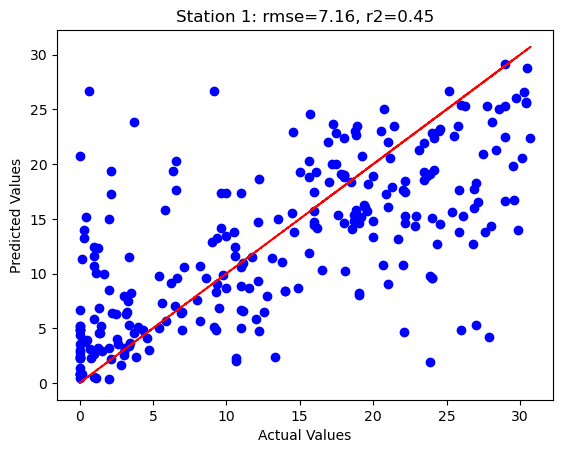

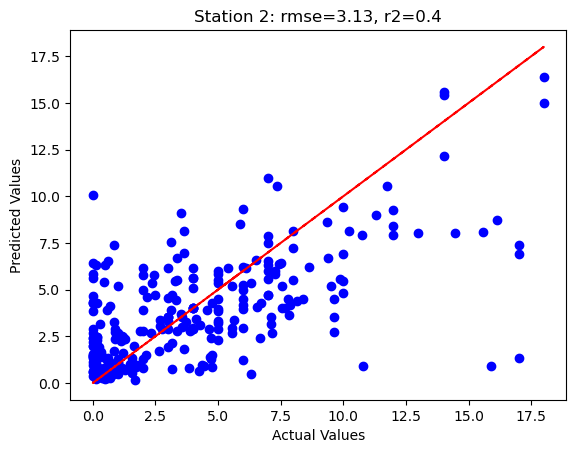

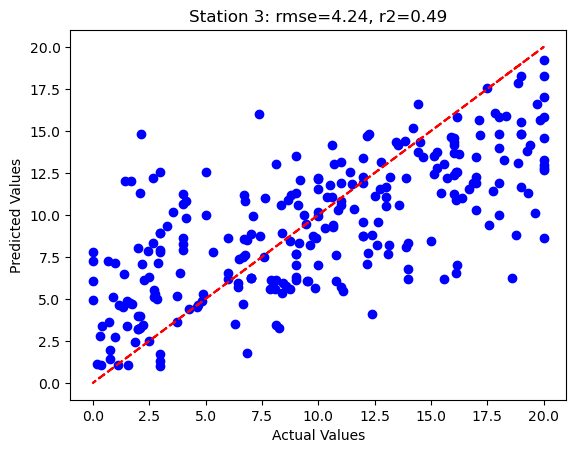

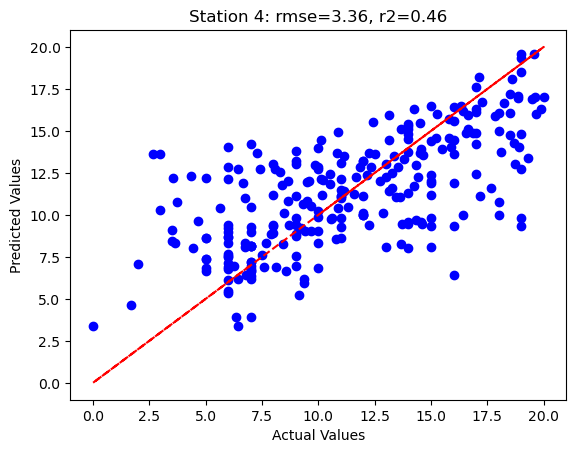

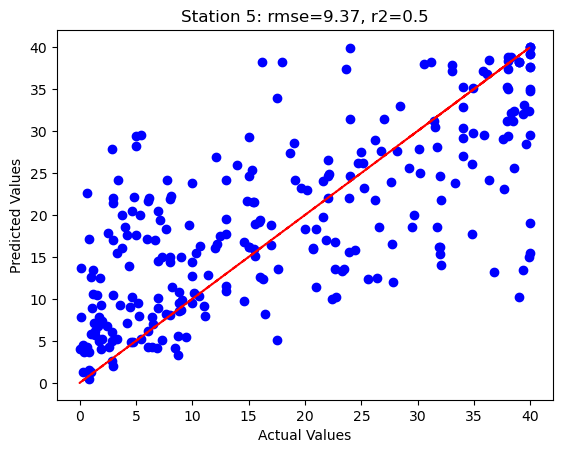

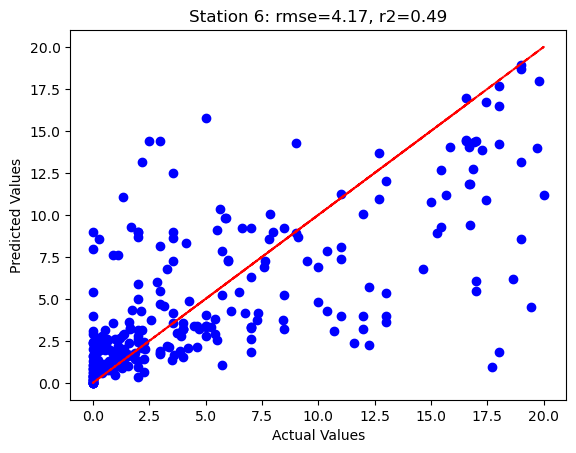

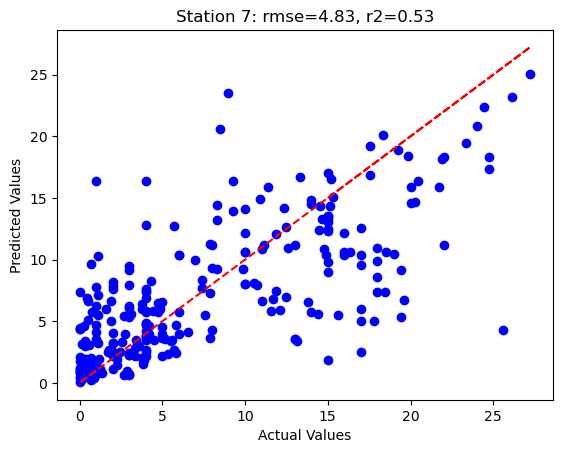

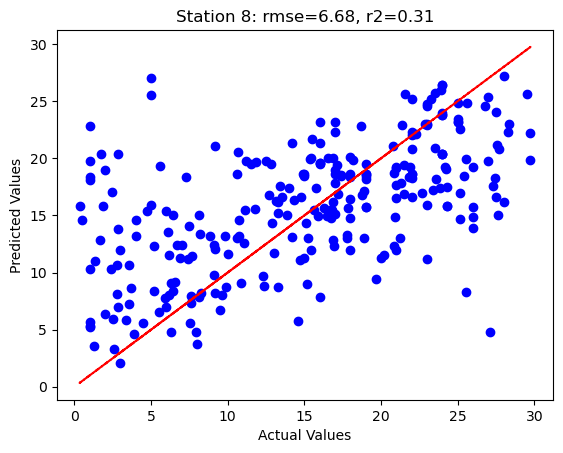

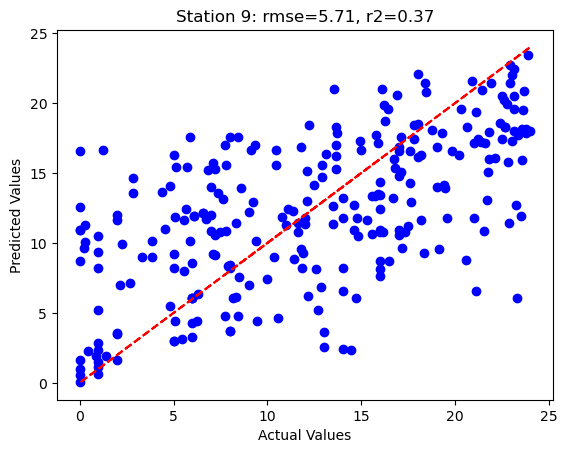

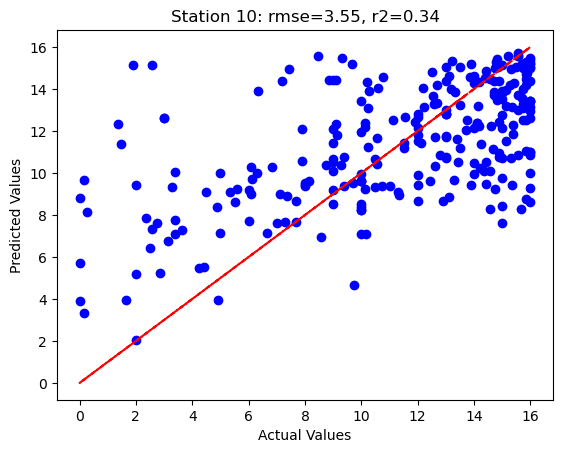

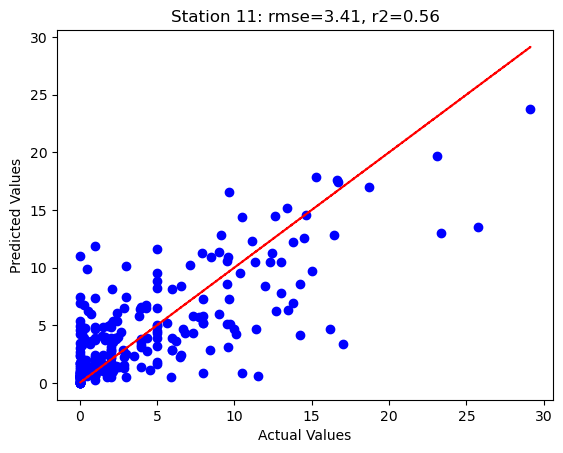

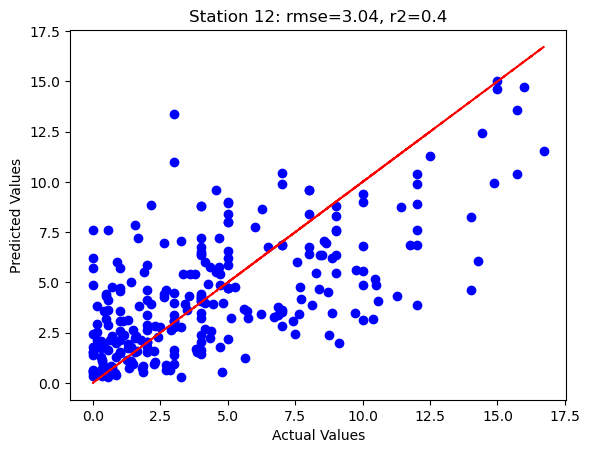

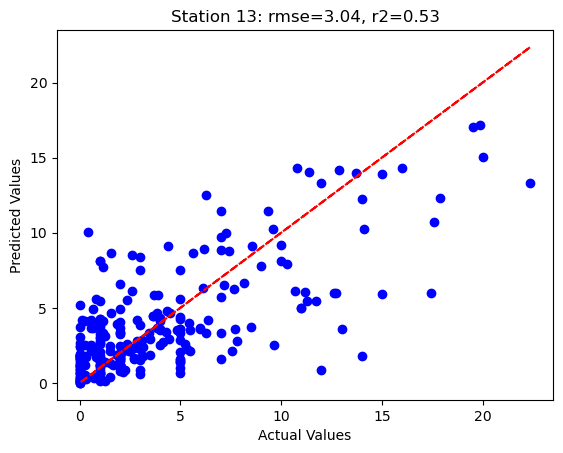

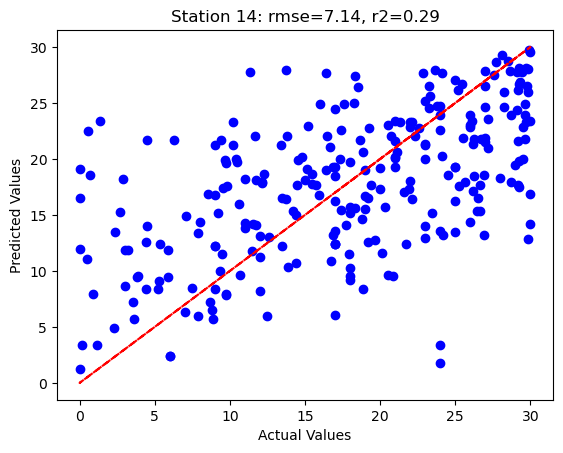

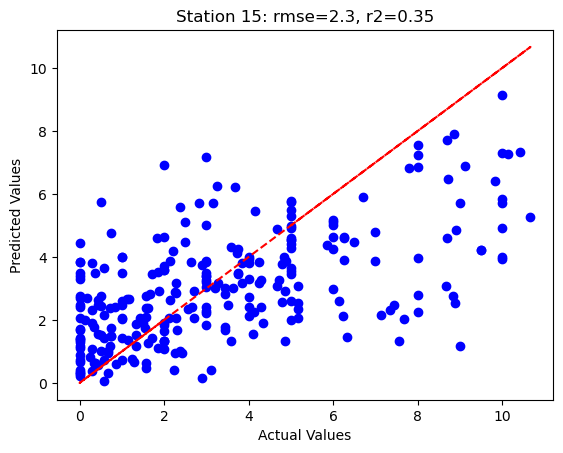

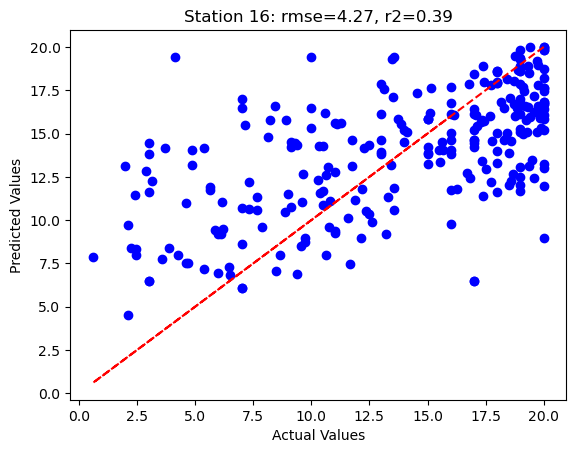

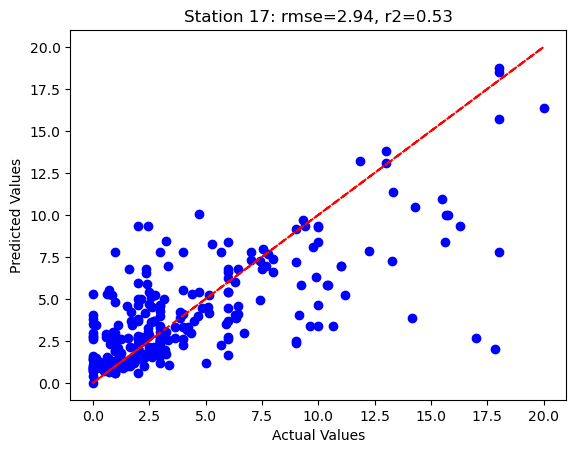

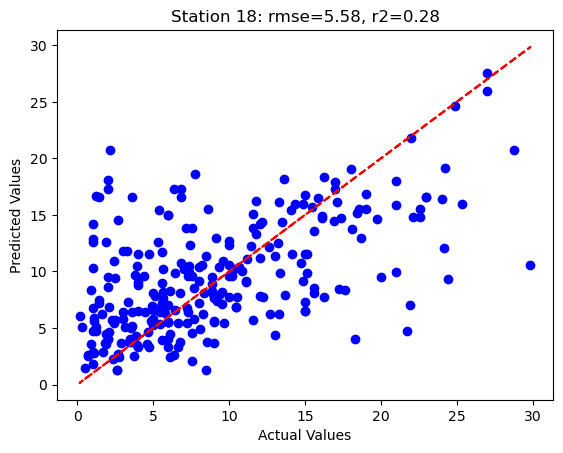

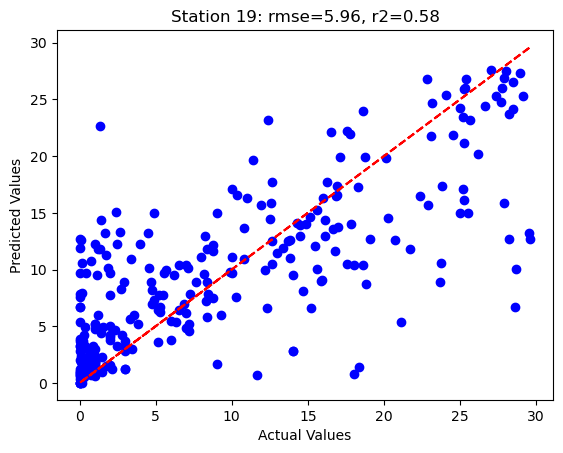

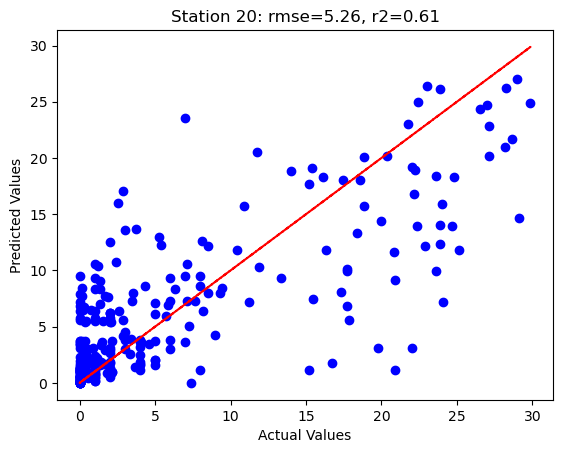

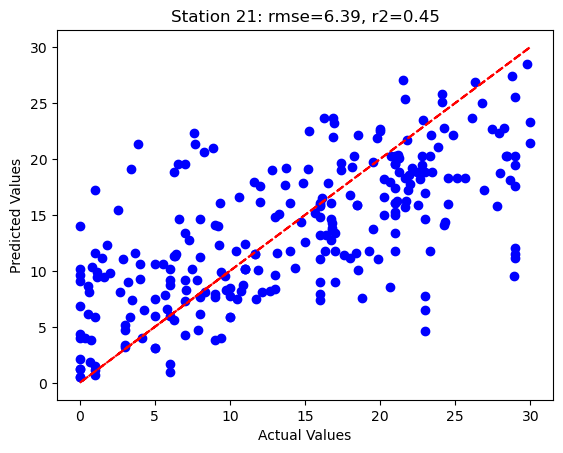

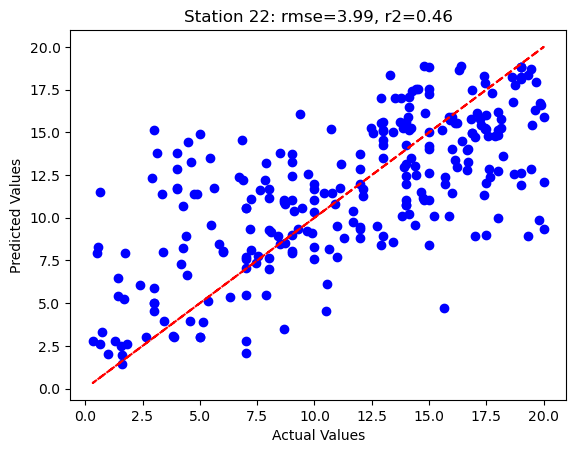

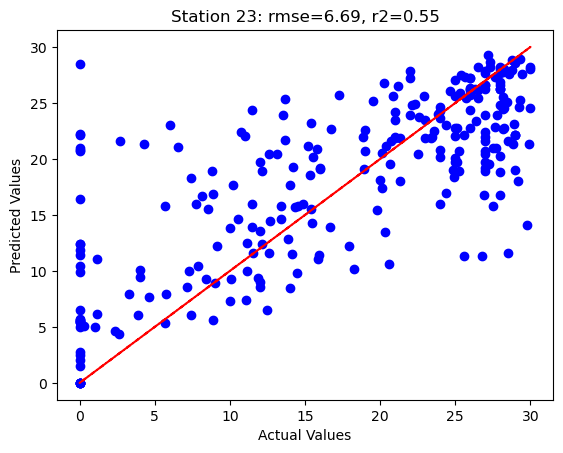

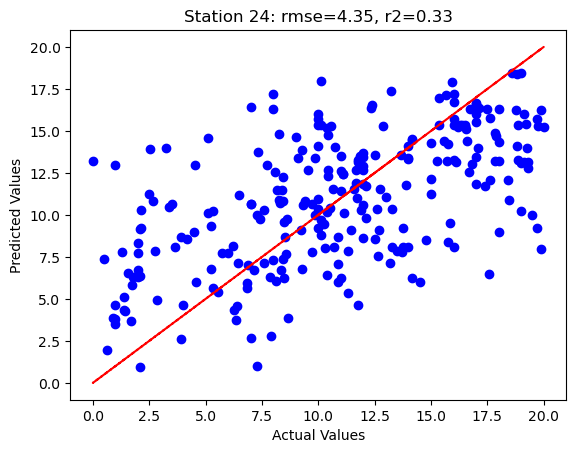

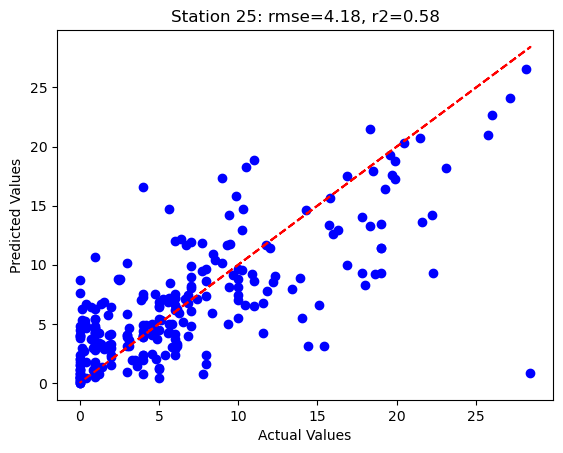

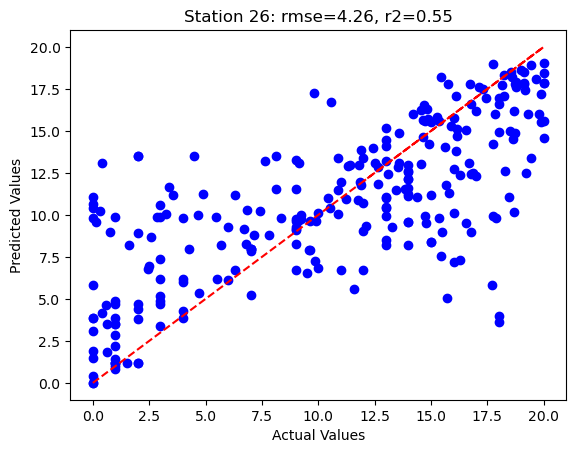

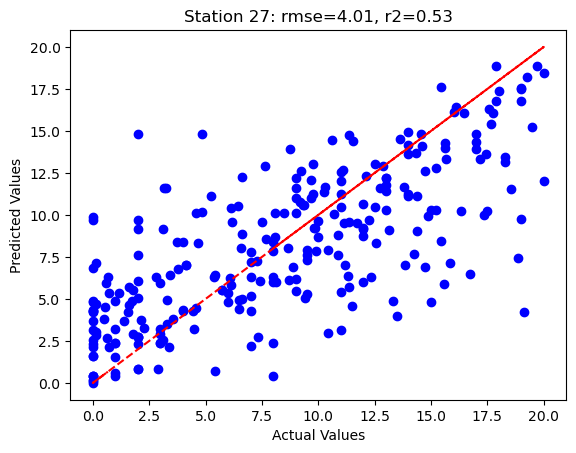

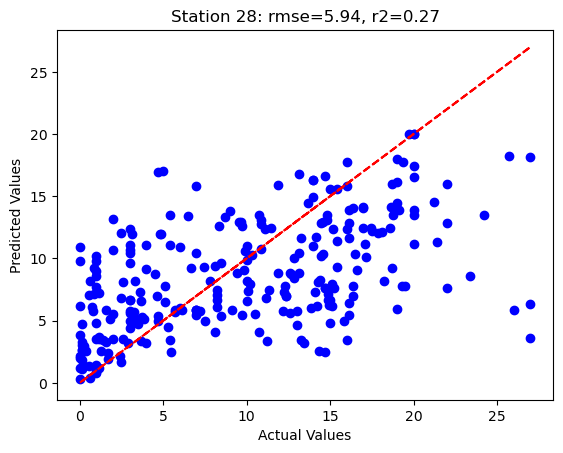

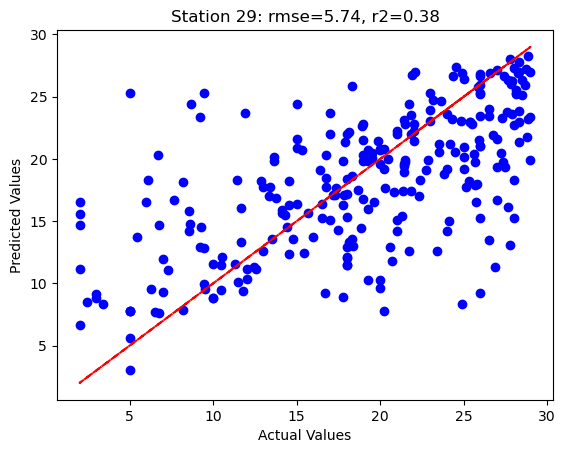

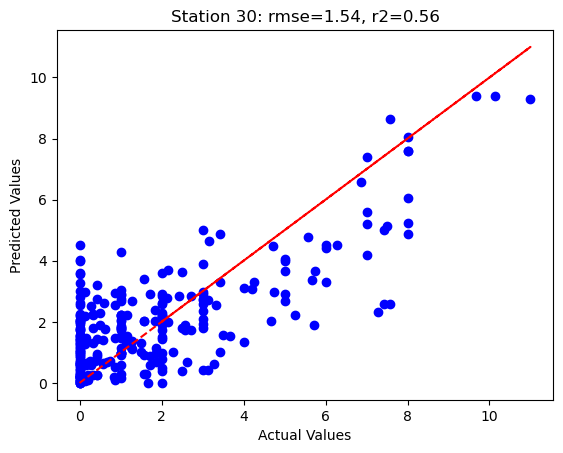

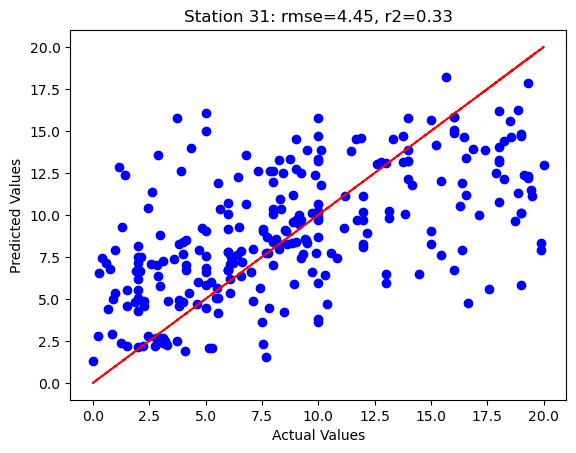

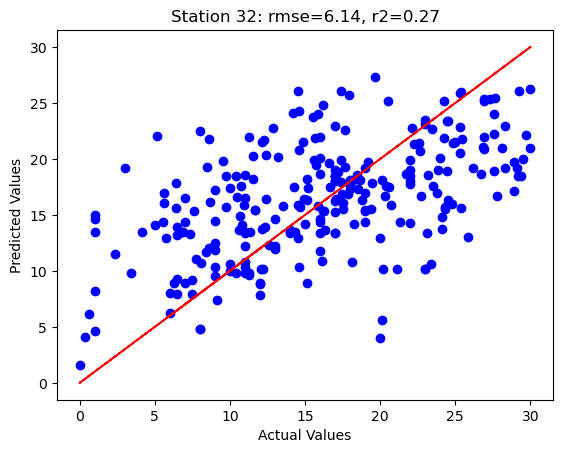

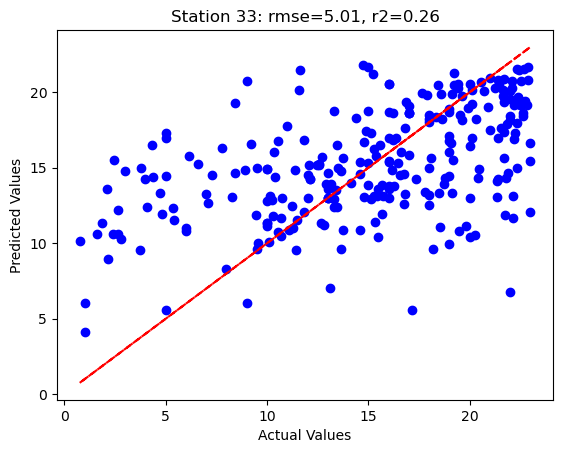

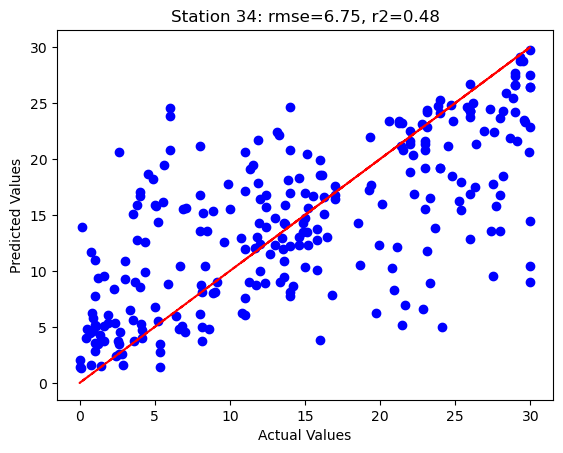

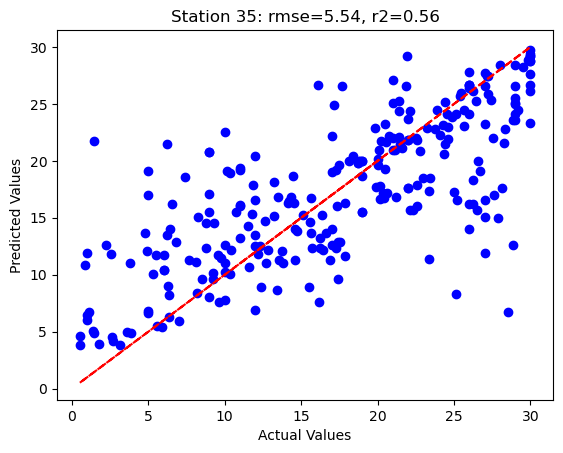

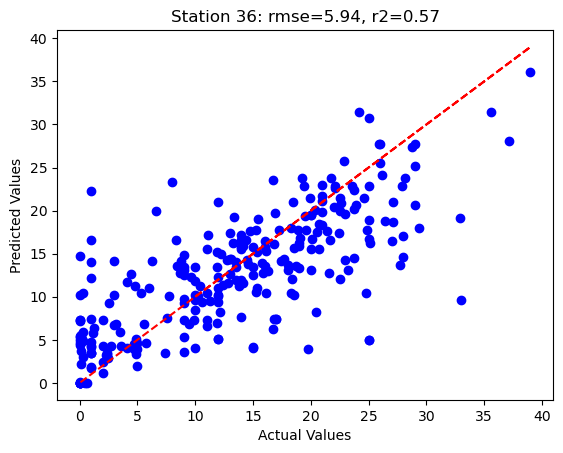

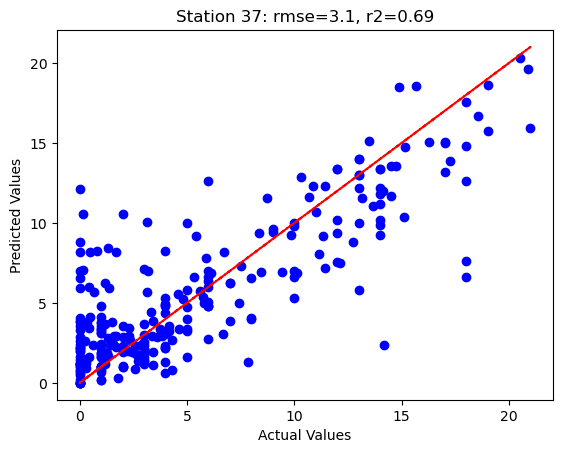

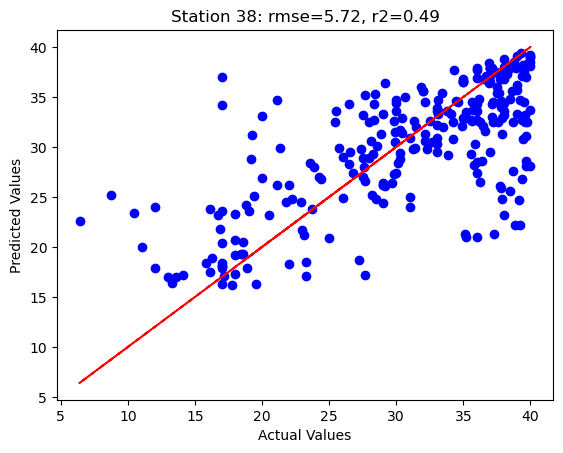

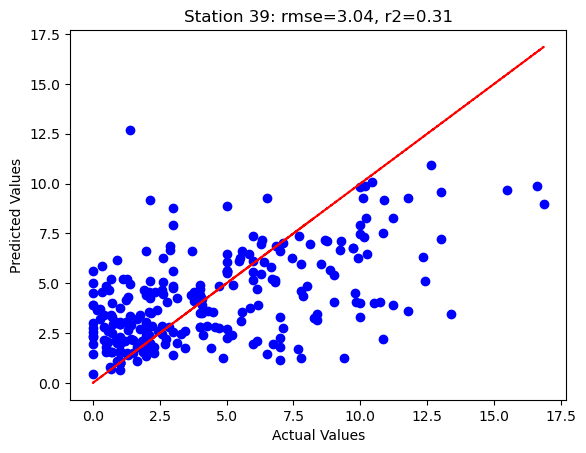

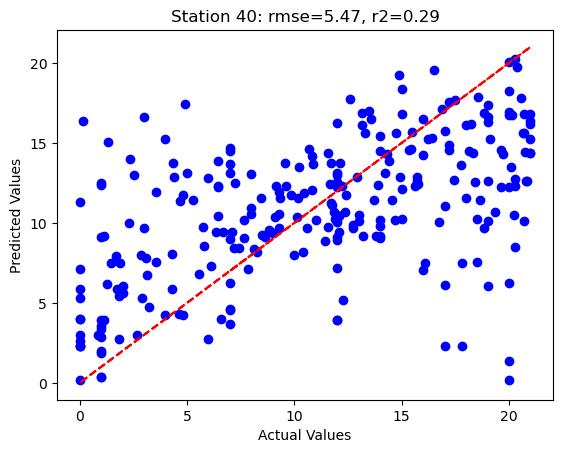

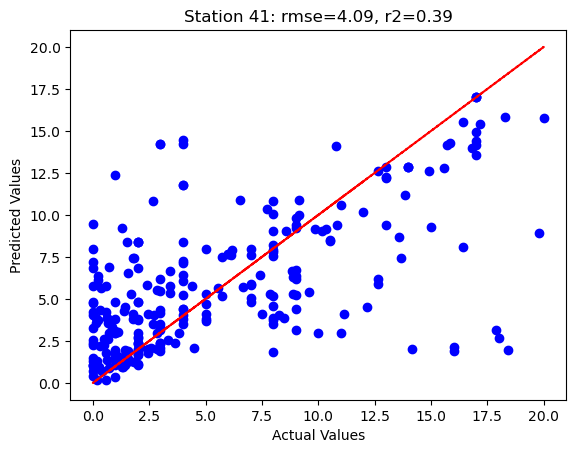

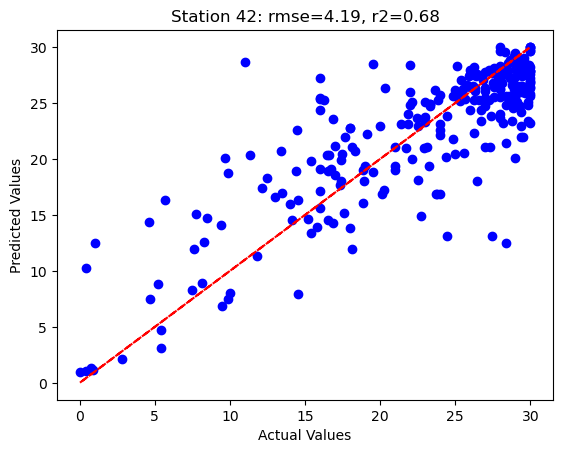

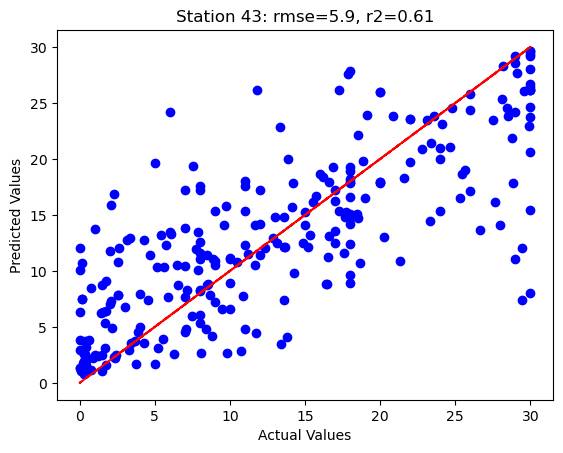

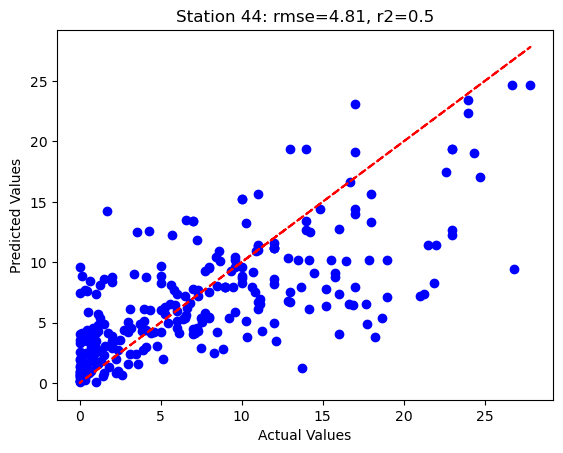

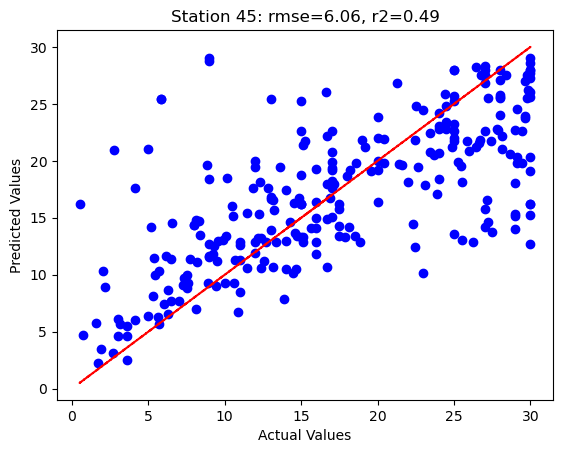

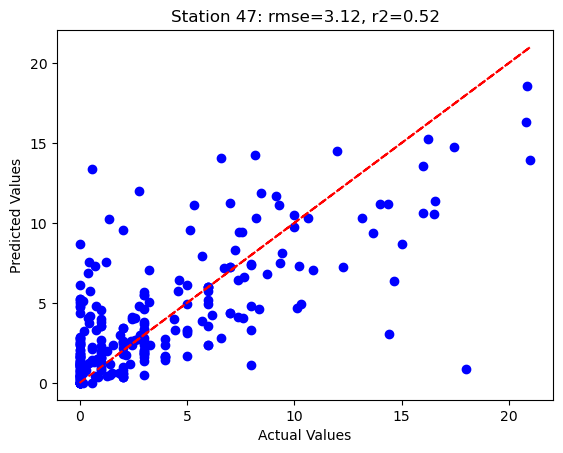

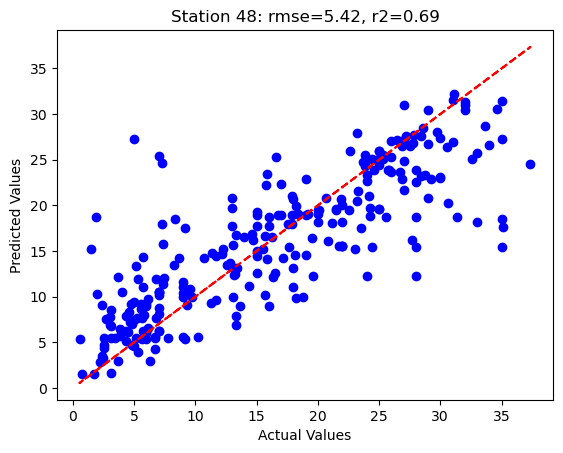

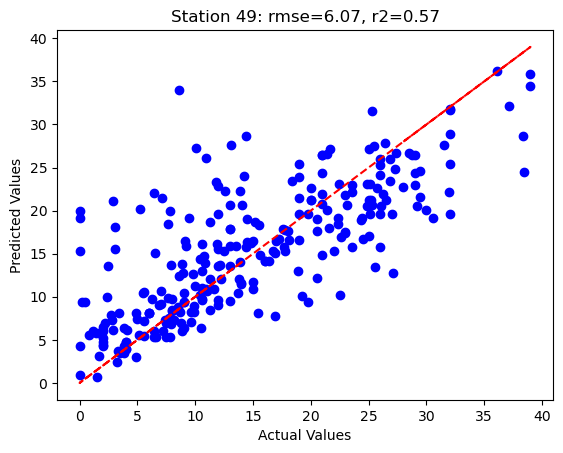

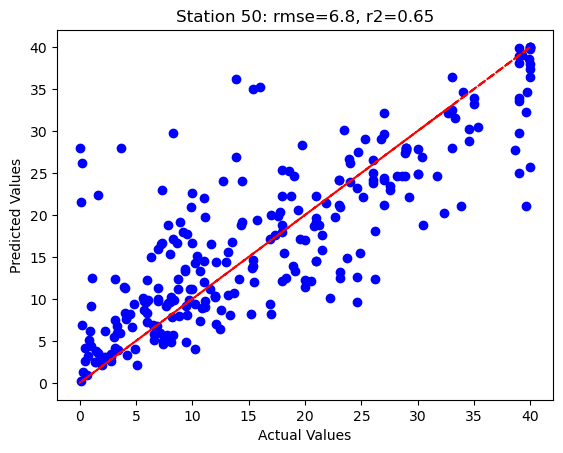

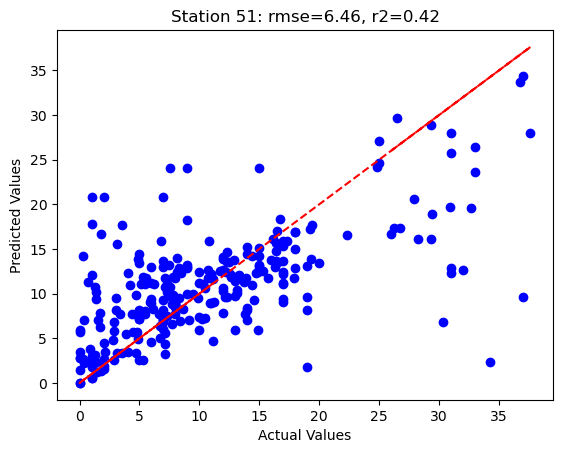

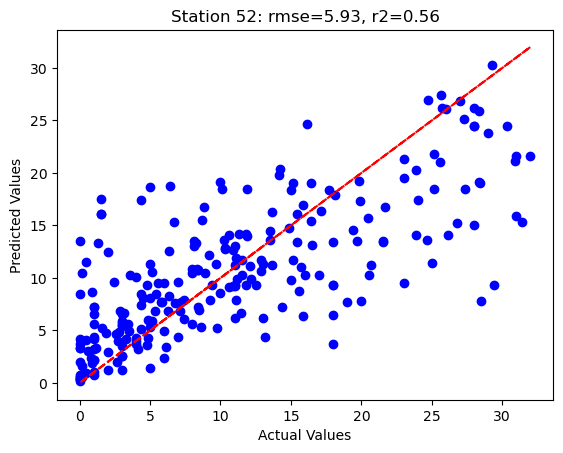

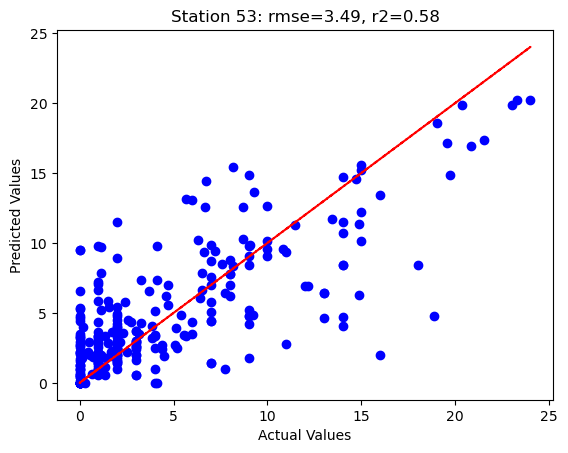

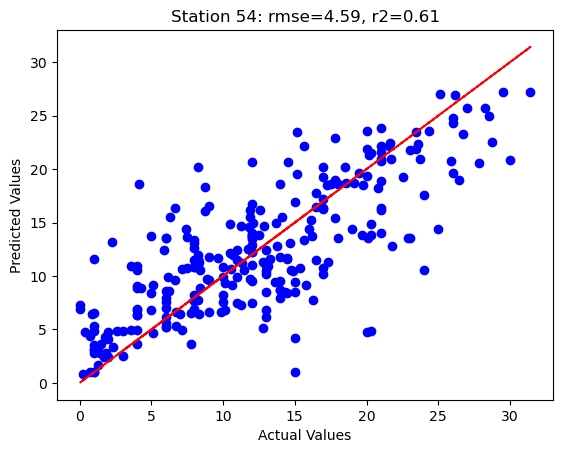

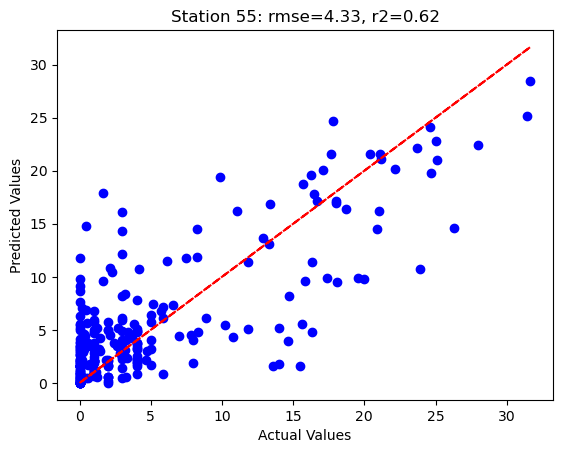

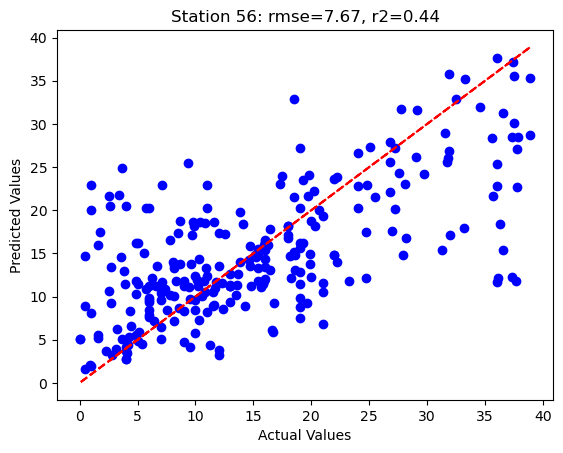

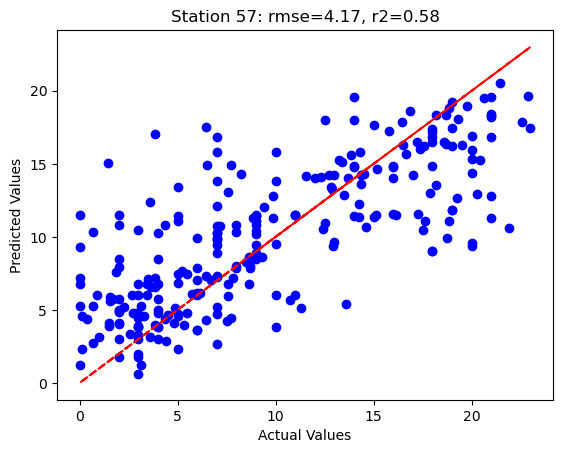

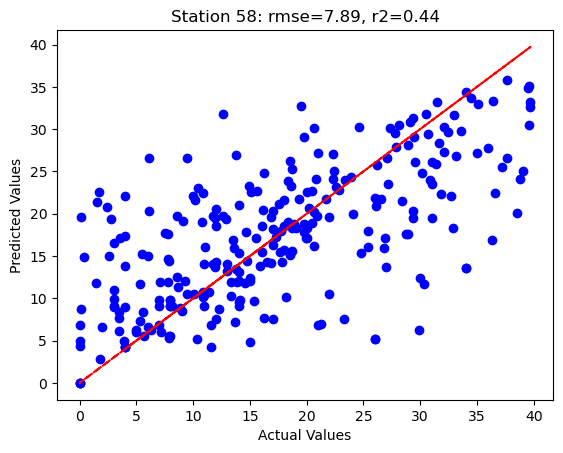

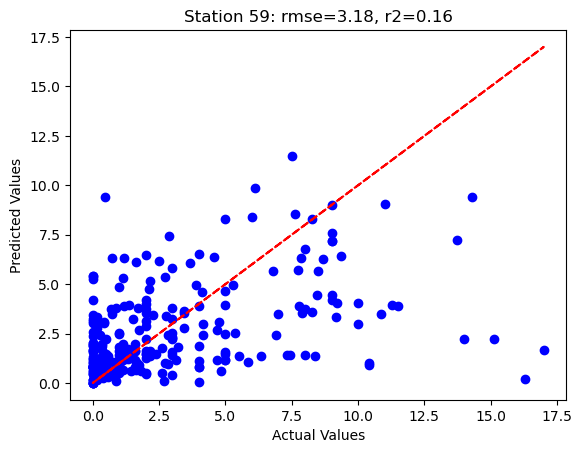

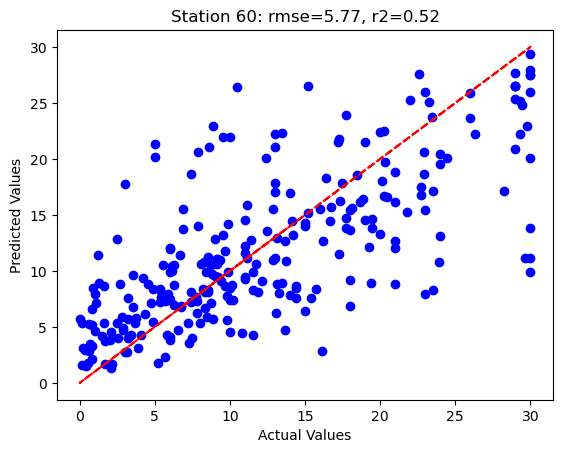

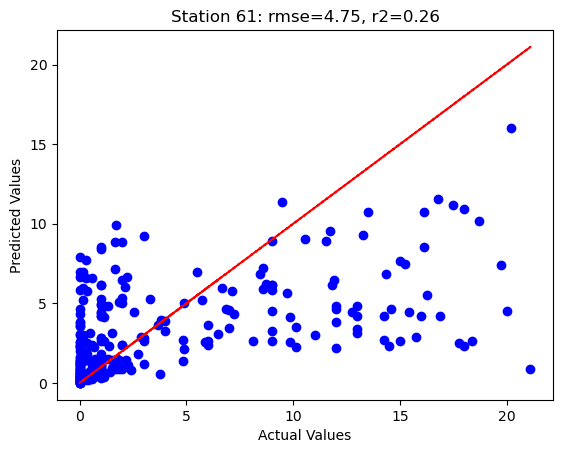

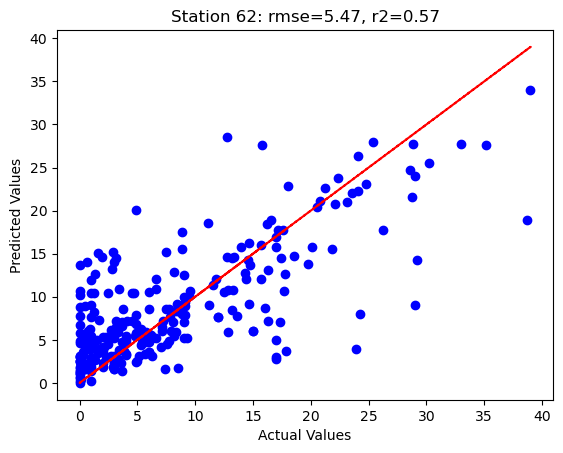

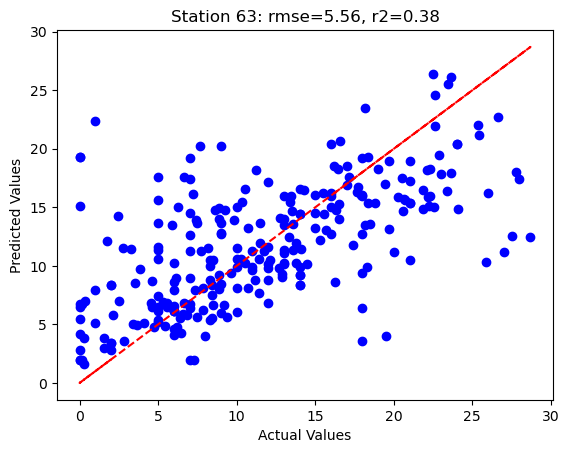

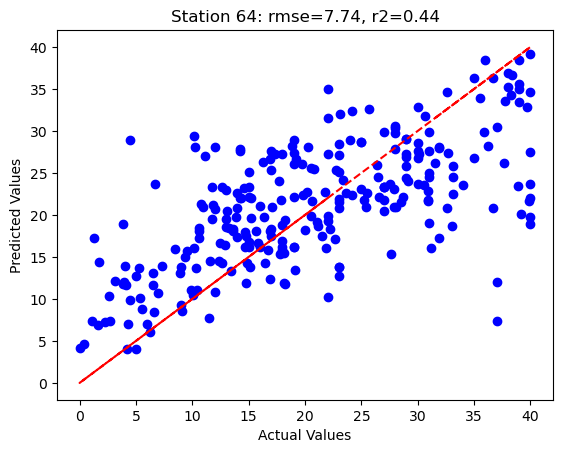

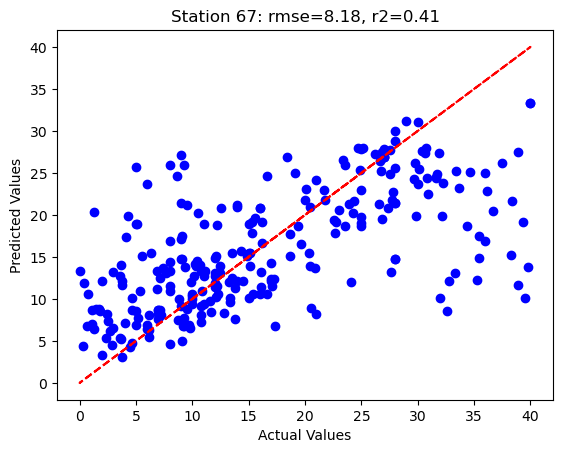

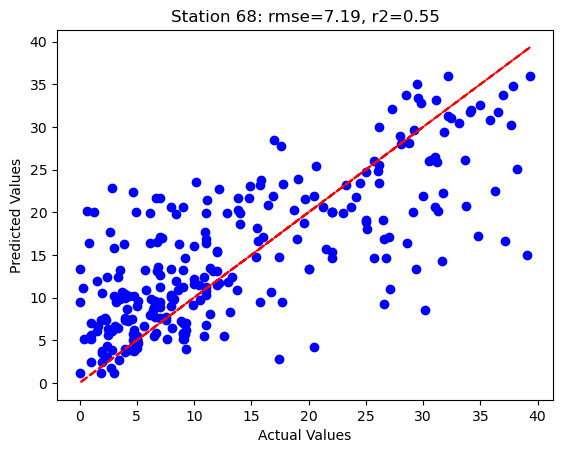

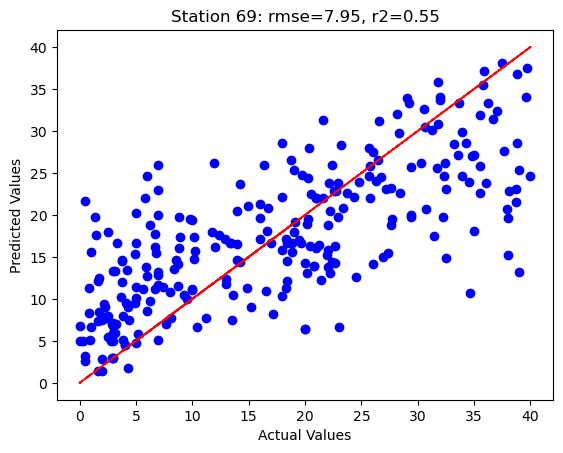

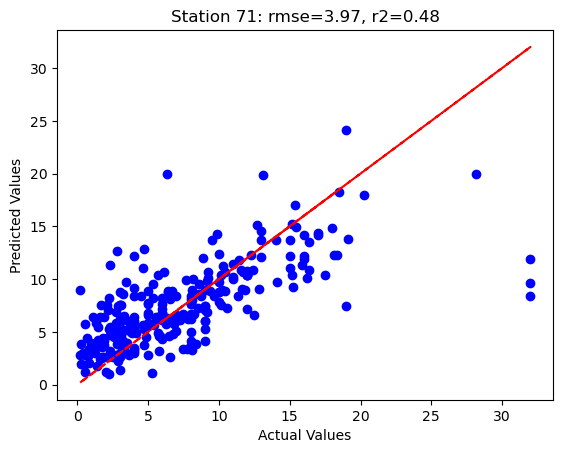

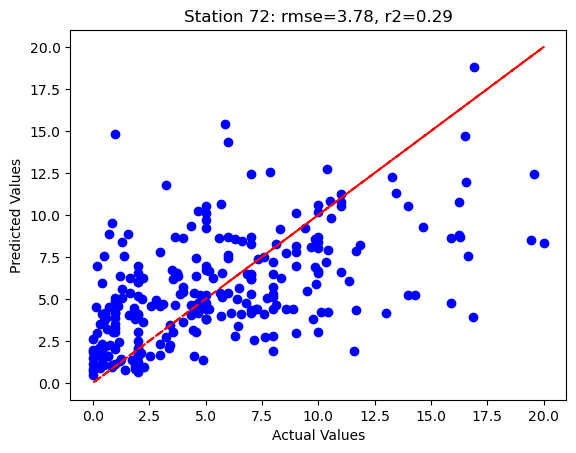

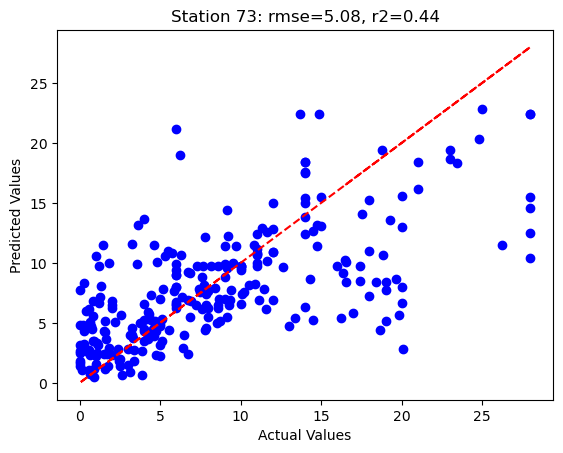

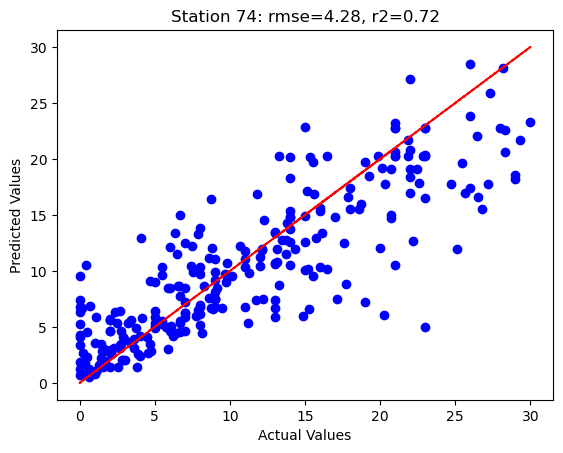

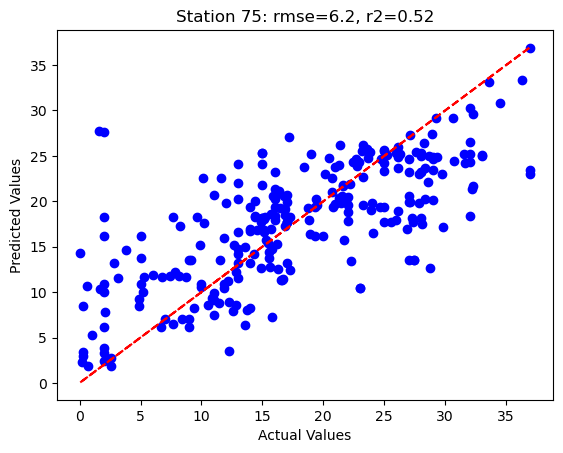

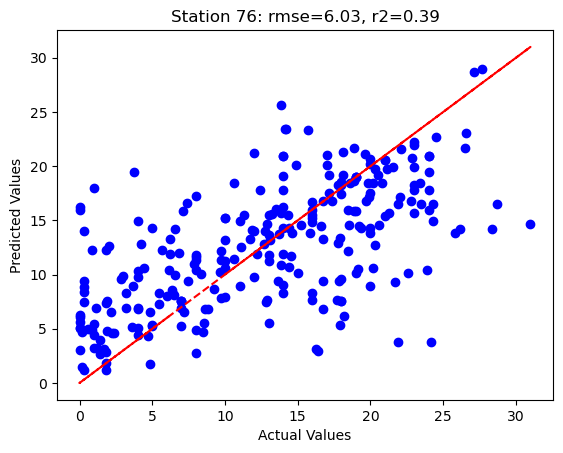

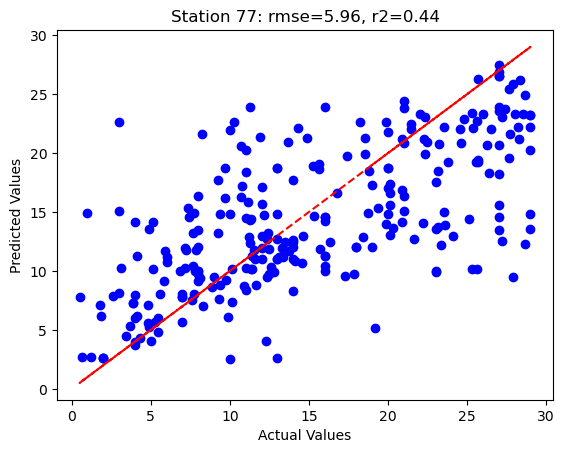

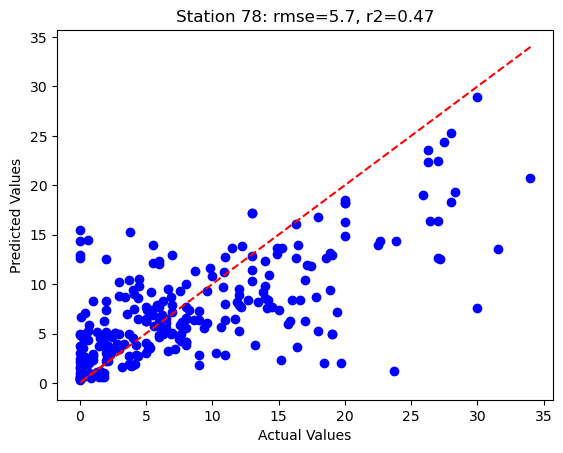

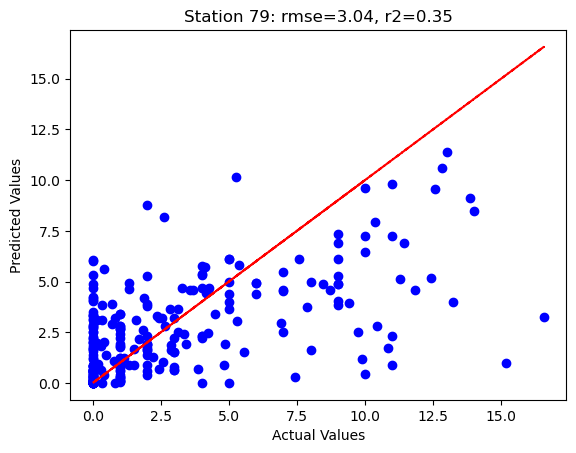

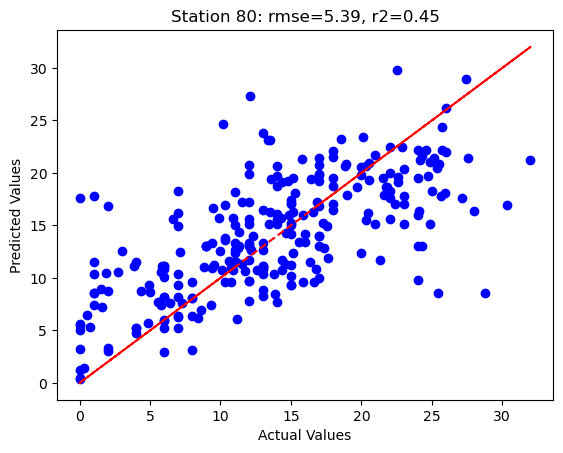

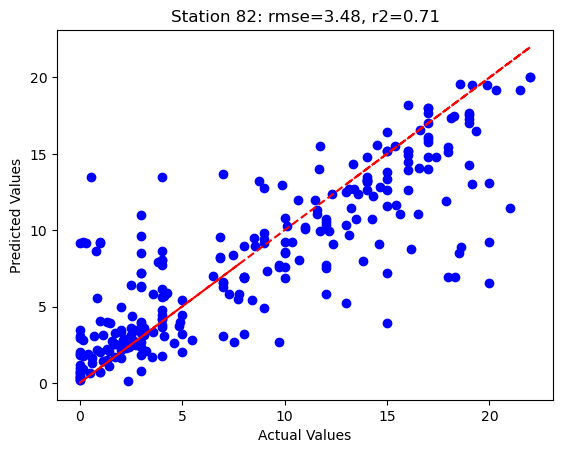

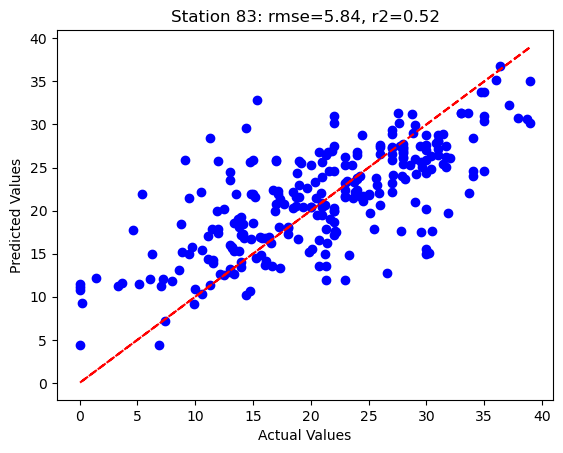

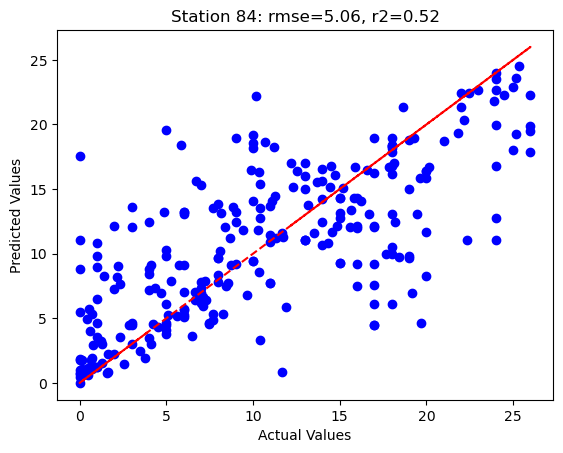

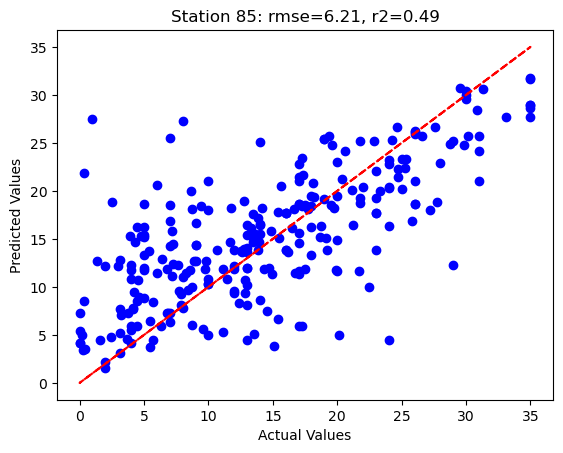

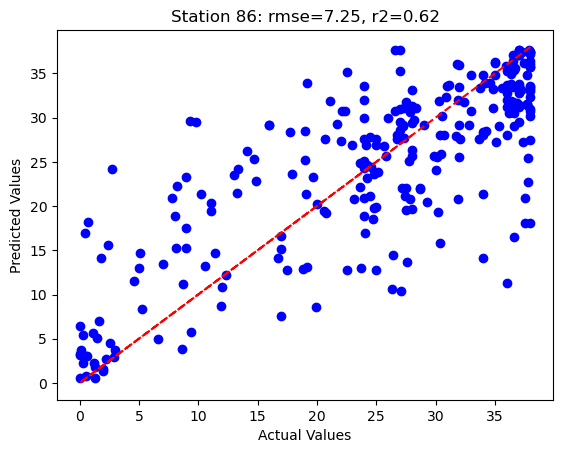

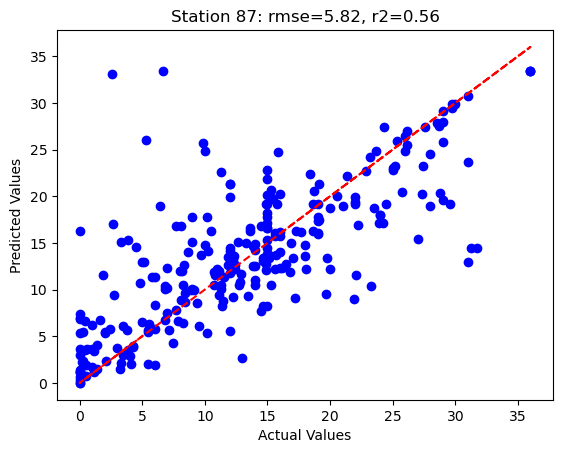

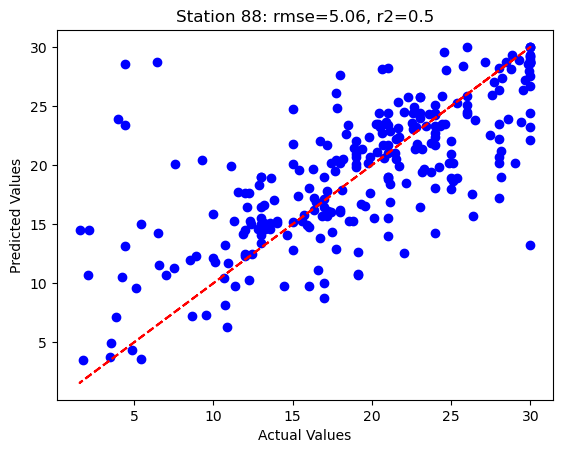

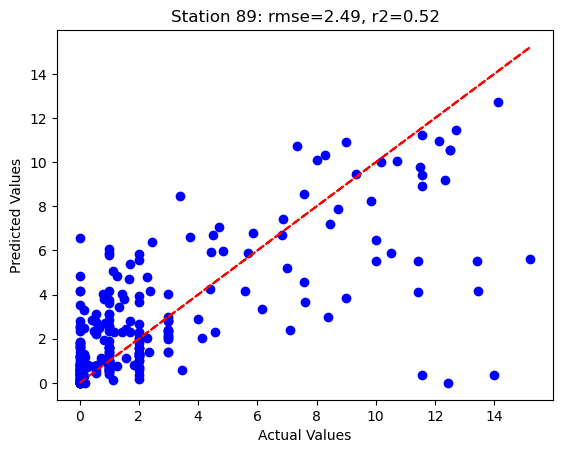

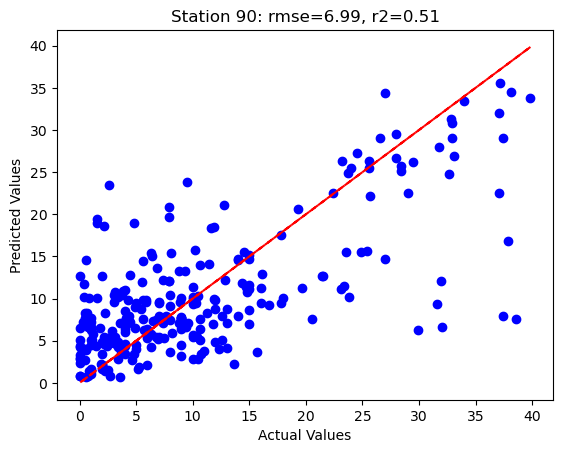

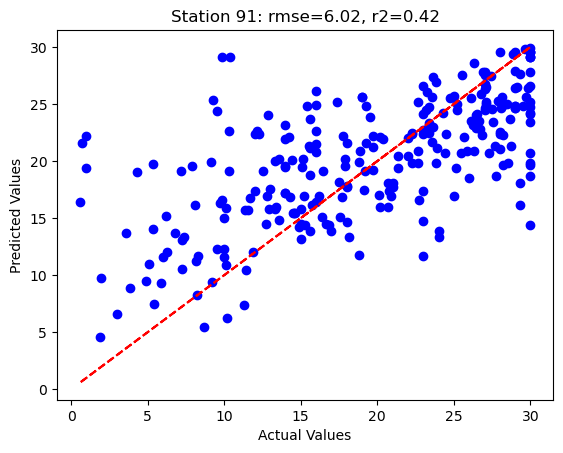

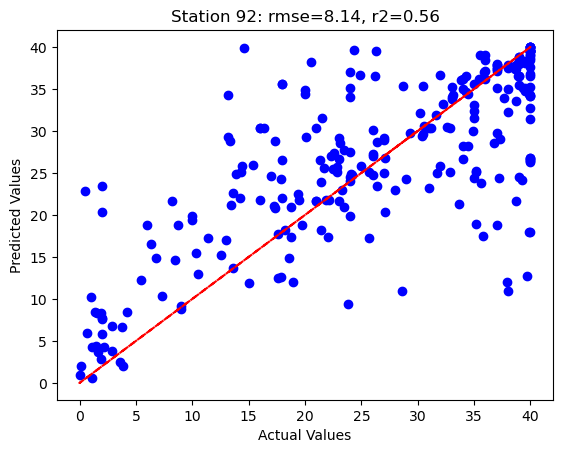

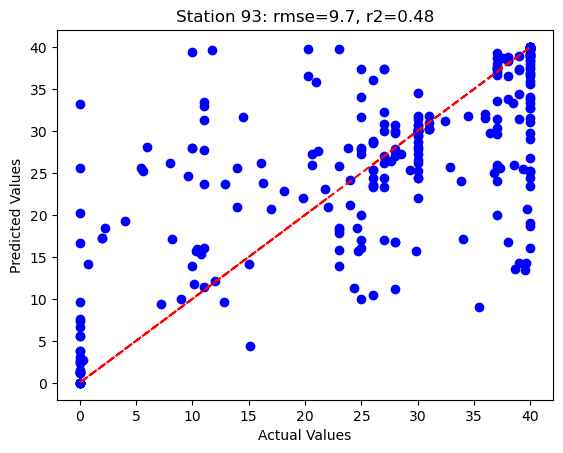

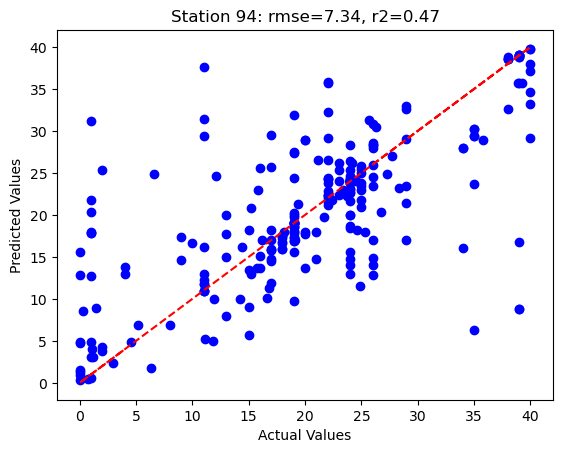

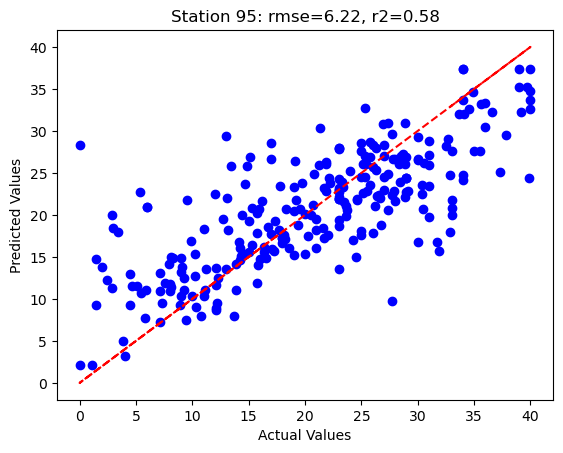

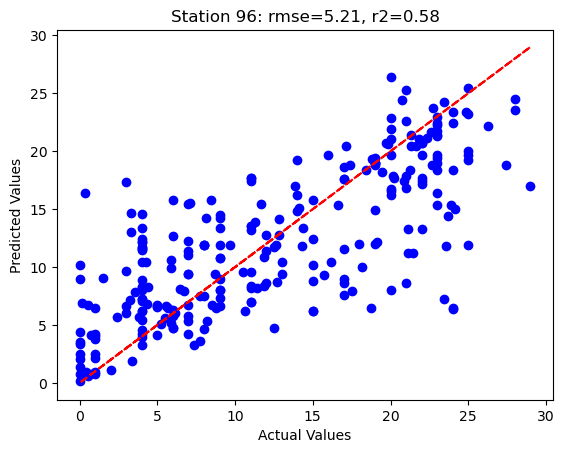

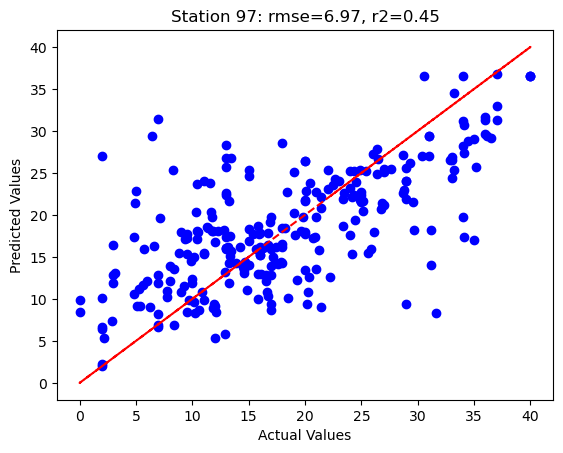

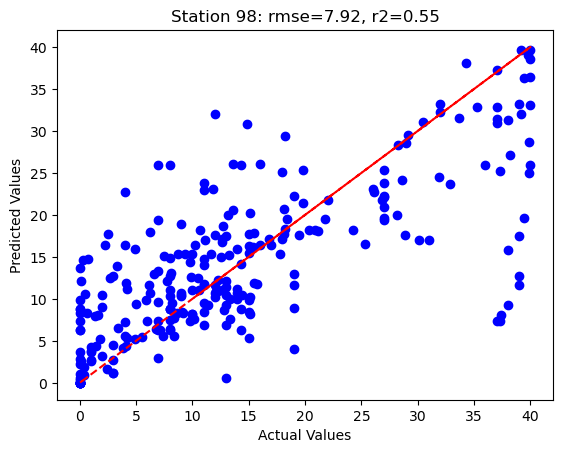

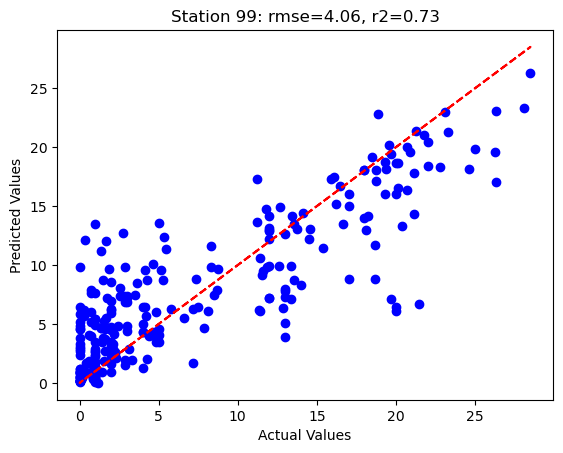

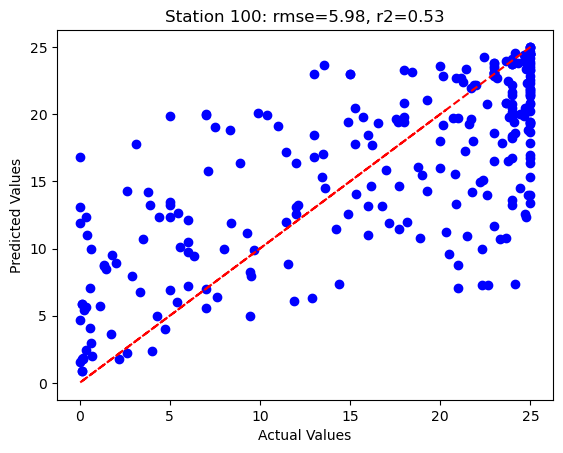

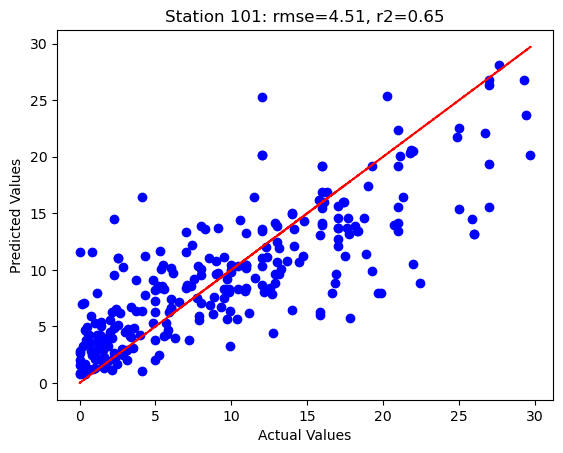

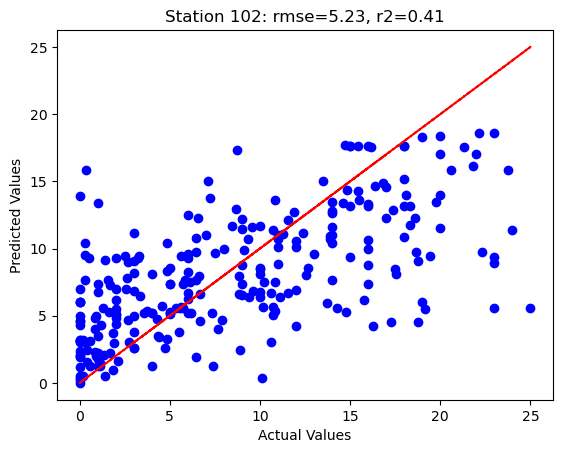

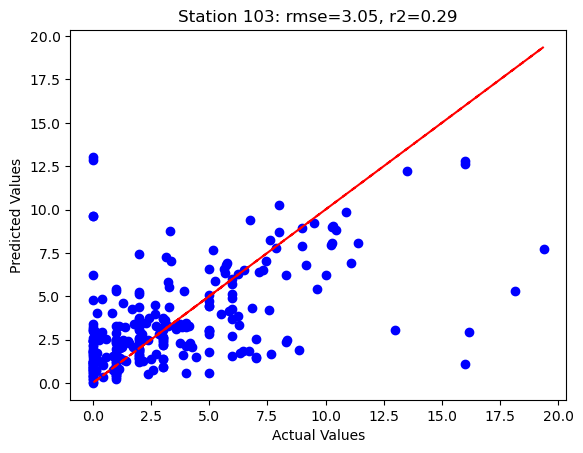

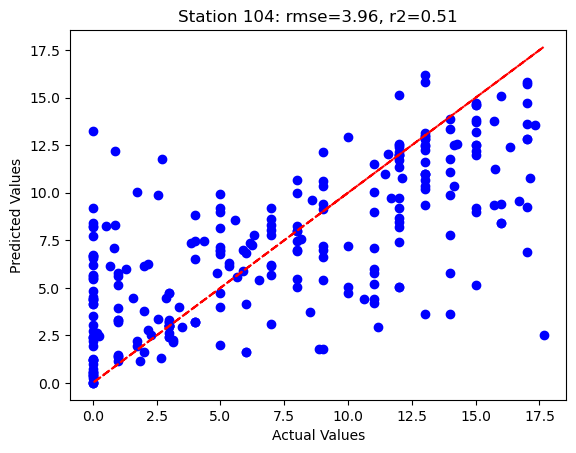

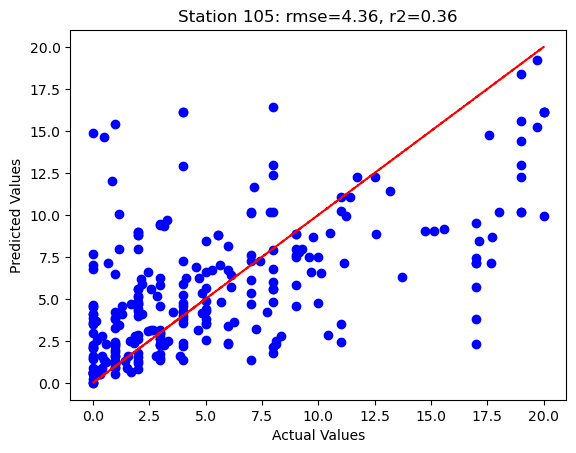

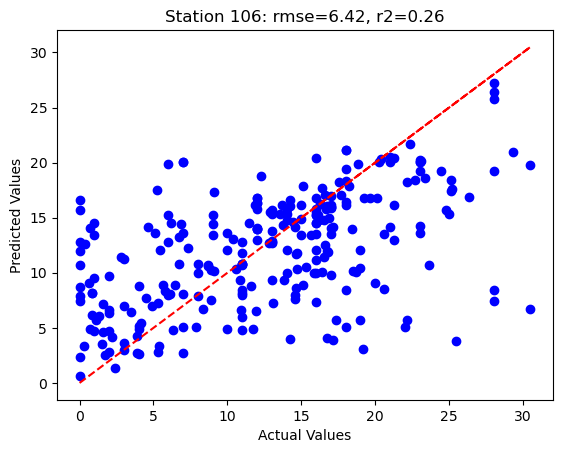

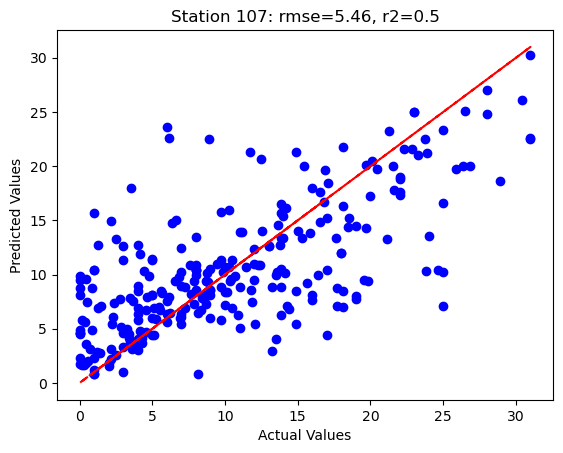

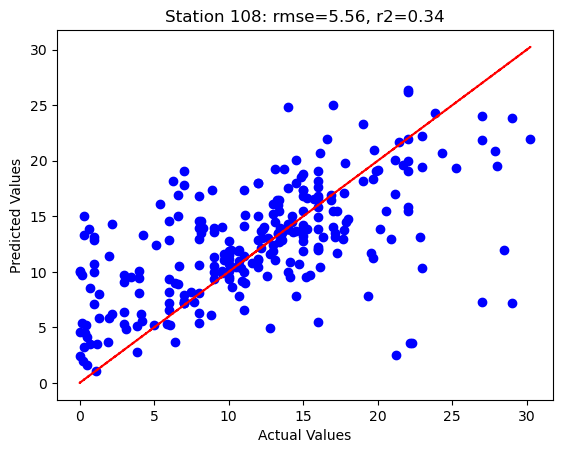

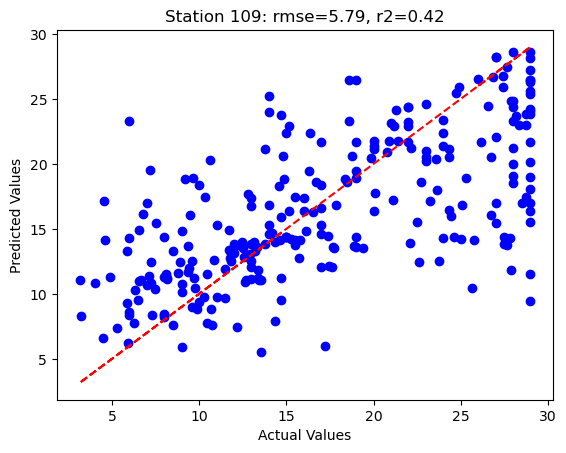

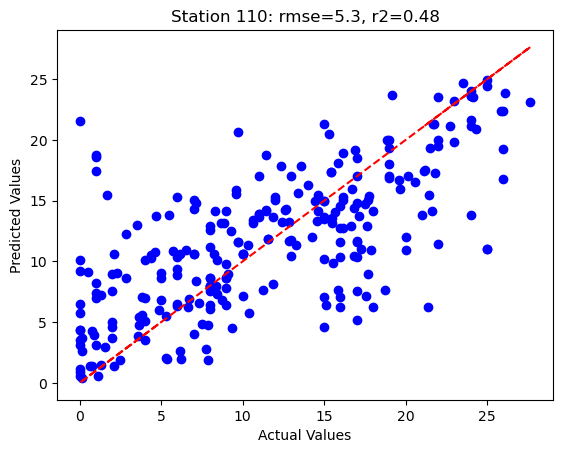

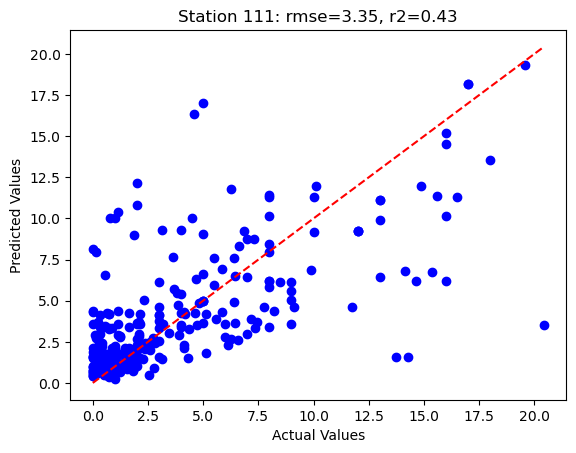

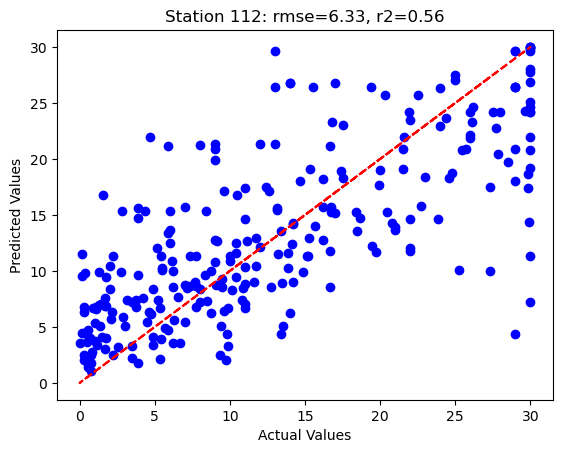

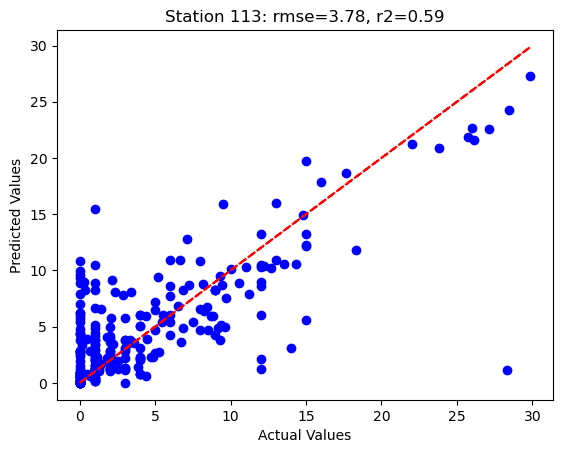

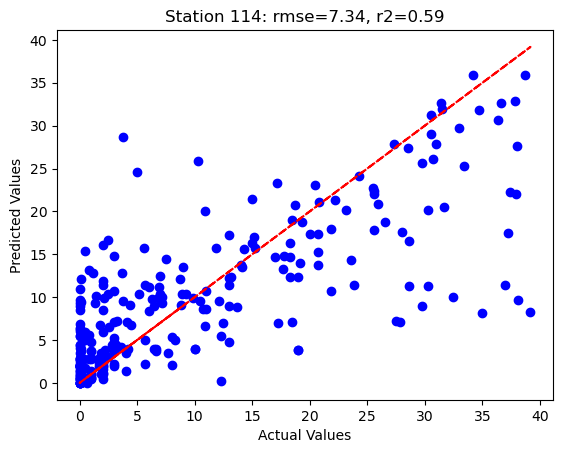

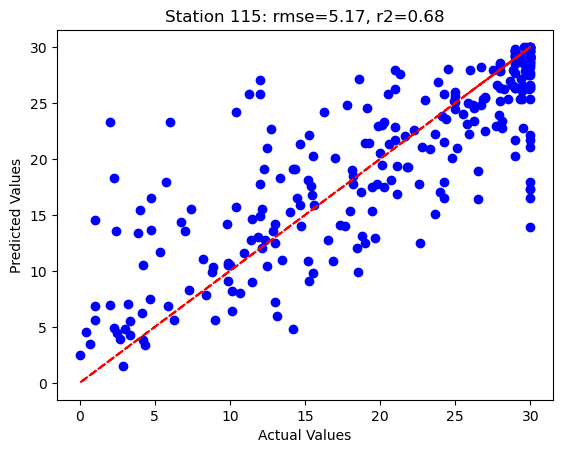

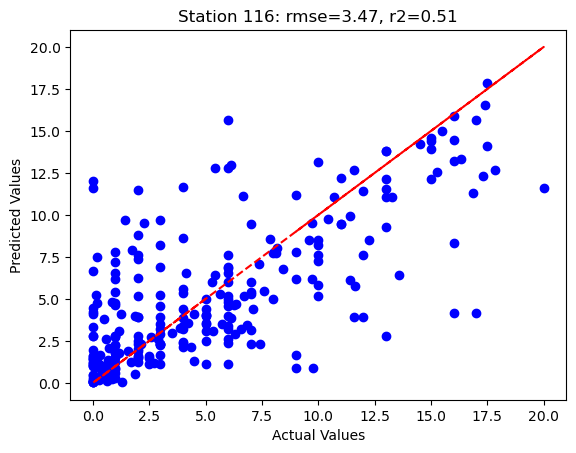

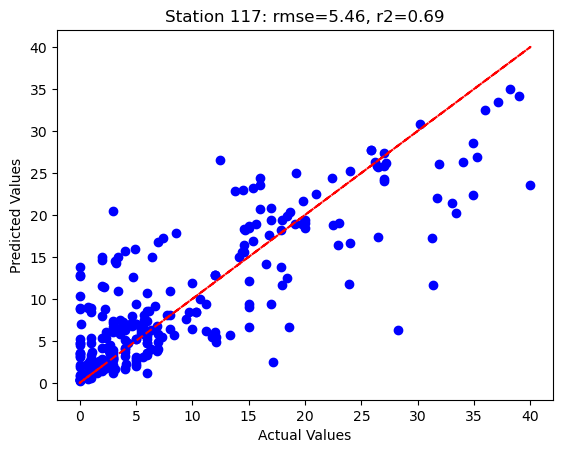

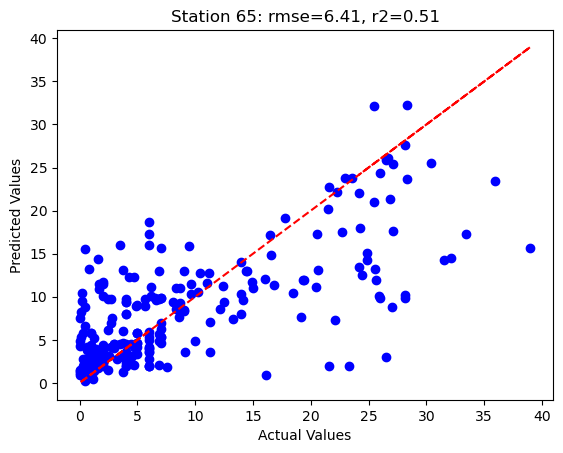

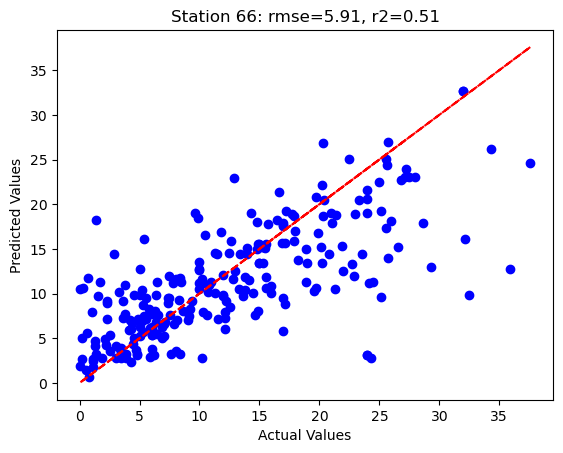

In [19]:
# Check the performance for each station
for i,number in enumerate(unique_numbers):
    # Predict with test set
    model = models[i]
    y_pred = model.predict(X_tests[i])
    # Evaluate the performance
    rmse = mean_squared_error(y_tests[i], y_pred, squared=False)
    r_squared = r2_score(y_tests[i], y_pred)
    # Plot the result
    plt.scatter(y_tests[i], y_pred, color='blue', label='Observations')
    plt.plot(y_tests[i], y_tests[i], color='red', linestyle='--', label='y=x')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Station {number}: rmse={round(rmse,2)}, r2={round(r_squared,2)}')
    plt.show()